<font size="20"> <center> **Popubile**
<br><br>
<font size="5"> <center> **HIT<br>
“Introduction to data science” final project<br><br>
By Omer Elazar**

# Tabel of contents

### [Abstract](#abstract)

### [Importing Libraries](#ImportingLibraries)

### [Data Acquisition](#dataAcquisition)
 - [Scraping GSMArena](#ScrapingGSMArena)
 - [Getting brand countries](#Gettingbrandcountries)
 - [Getting USD exchange rates](#GettingUSDexchangerates)

### [Data Cleaning](#DataCleaning)
 - [Extracting numeric data](#Extractingnumericdata)
 - [Adding country column](#Addingcountrycolumn)
 - [Handling missing values](#Handlingmissingvalues)
 - [Dealing with outliers](#Dealingwithoutliers)
 
### [EDA](#Eda)
 - [Catagorical Plots](#CatagoricalPlots)
 - [Maps](#Maps)
 - [Correlation Matrix](#CorrelationMatrix)

### [Machine Learning](#MachineLearning)
 - [Preparing The Data](#PreparingTheData)
 - [Comparing The Models](#ComparingTheModels)
 - [Hyperparameter Tuning](#HyperparameterTuning)
 - [Final Evaluation](#FinalEvaluation)

# <a class="anchor" id="abstract"></a> Abstract

#### Can you predict the popularity (hits and fans on GSMArena) of a phone knowing its brand and technical specification ?

What makes one phone gain more attention than others?
Is the brand and technical specification enough to know how popular a phone will be?

In this project I try to ansewr these questions by scraping data on 11,000 phones from GSMArena and implementing machine learning methods to try and predict the number of hits and fans a phone will get.

# <a class="anchor" id="ImportingLibraries"></a> Importing Libraries

In [82]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import requests
from bs4 import BeautifulSoup
import time

import pandas as pd
import csv
import json

import re

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas

from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# <a class="anchor" id="dataAcquisition"></a> Data Acquisition

**sources/credits:**
- https://selenium-python.readthedocs.io/index.html
- https://www.geeksforgeeks.org/how-to-convert-python-dictionary-to-json/
- https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe
- https://stackoverflow.com/questions/32381946/disabling-cookies-in-webdriver-for-chrome-firefox 

### <a class="anchor" id="ScrapingGSMArena"></a> Scraping GSMArena

In this section we use selenium to crawl through https://www.gsmarena.com/ and scrape all the phones data.

First we get all the links to each brand:

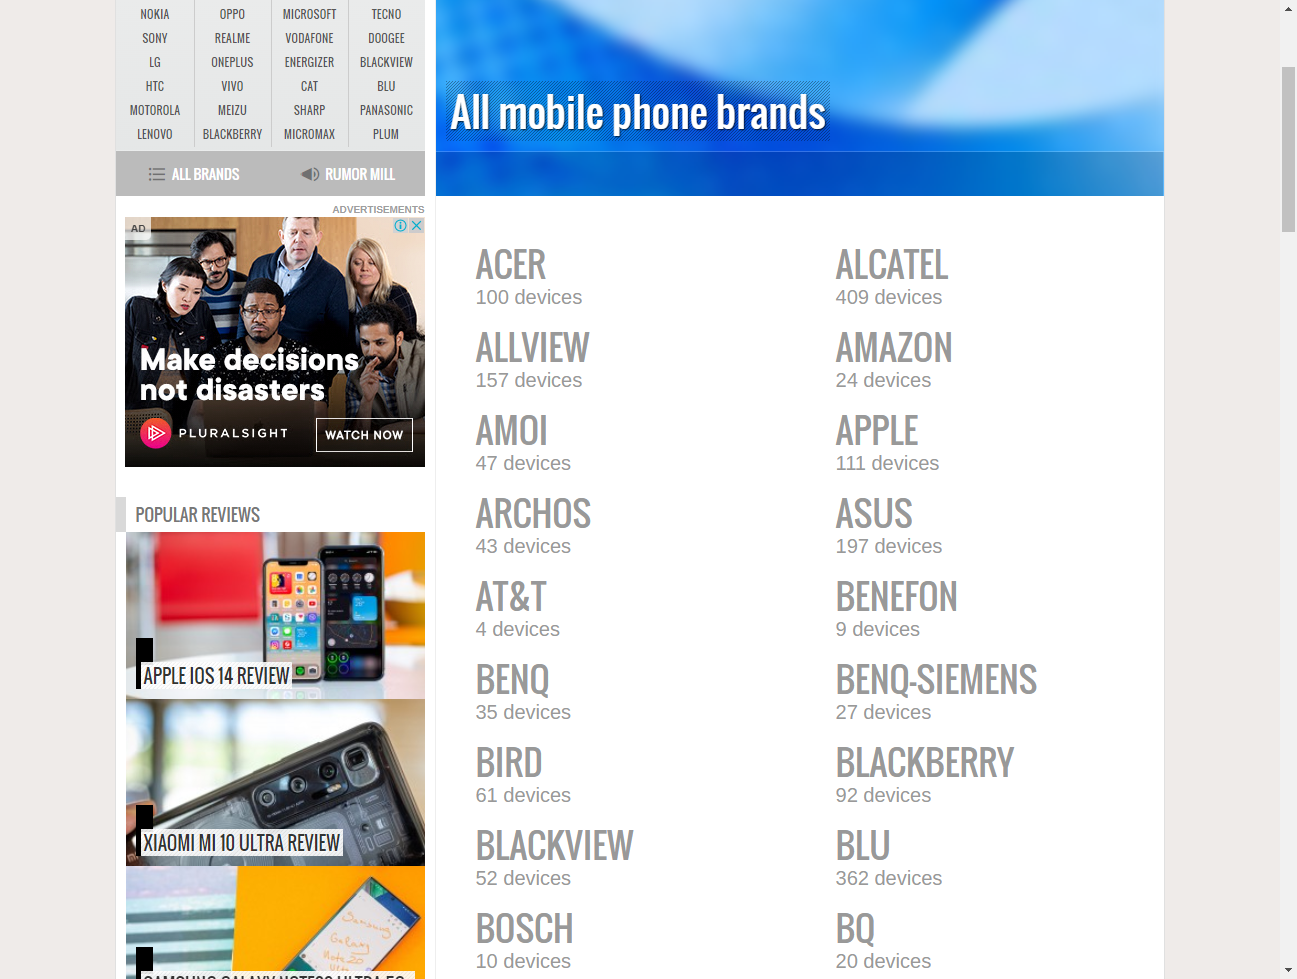

We then iterate though all pages of each brand and get all the links to every device:

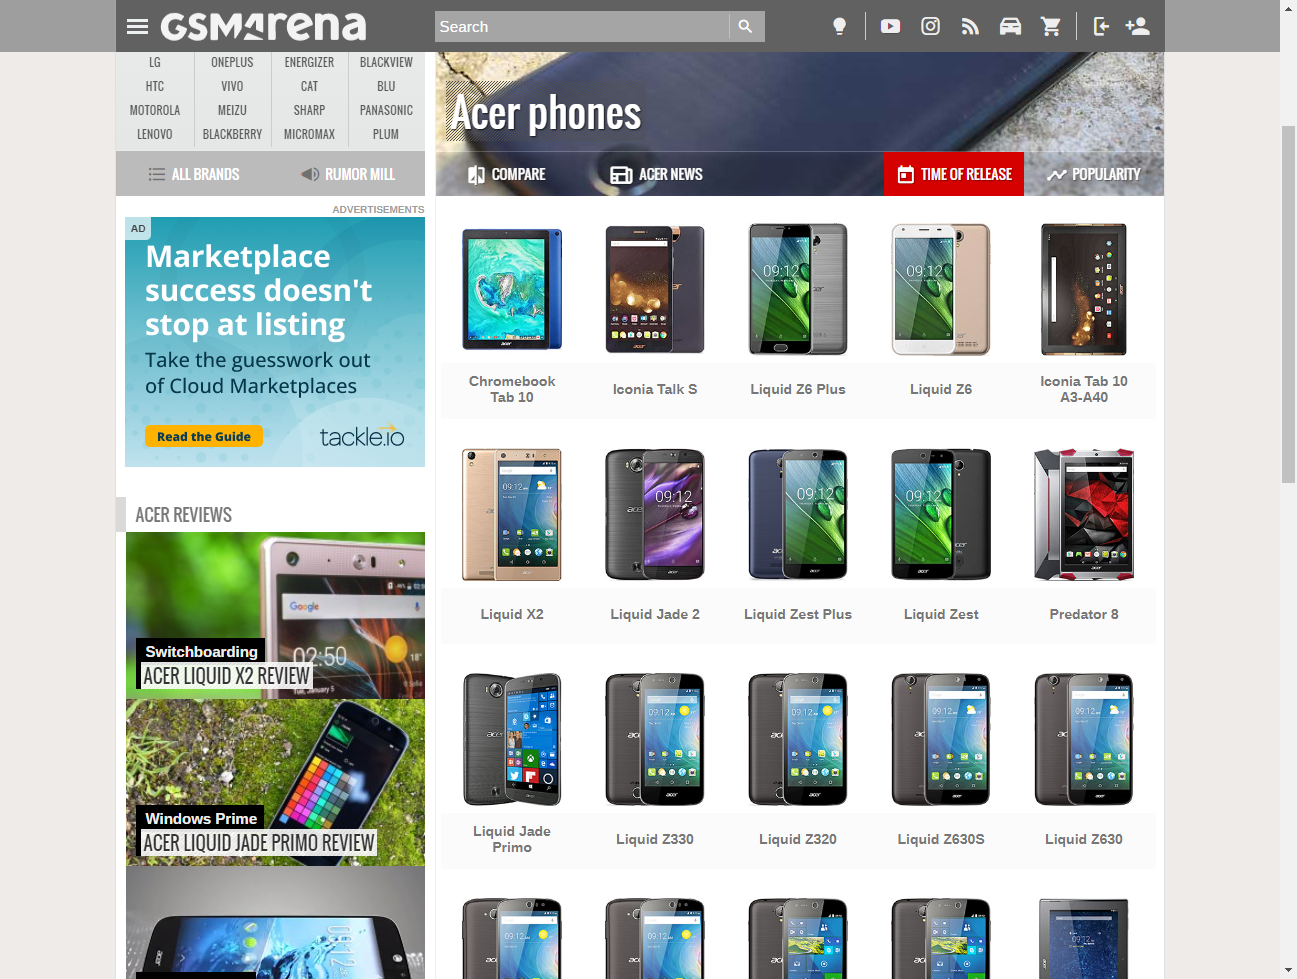

We also use the sites "finder" feature to find all the links to watches and tablets on the site so we can exclude them from the links we acquired:

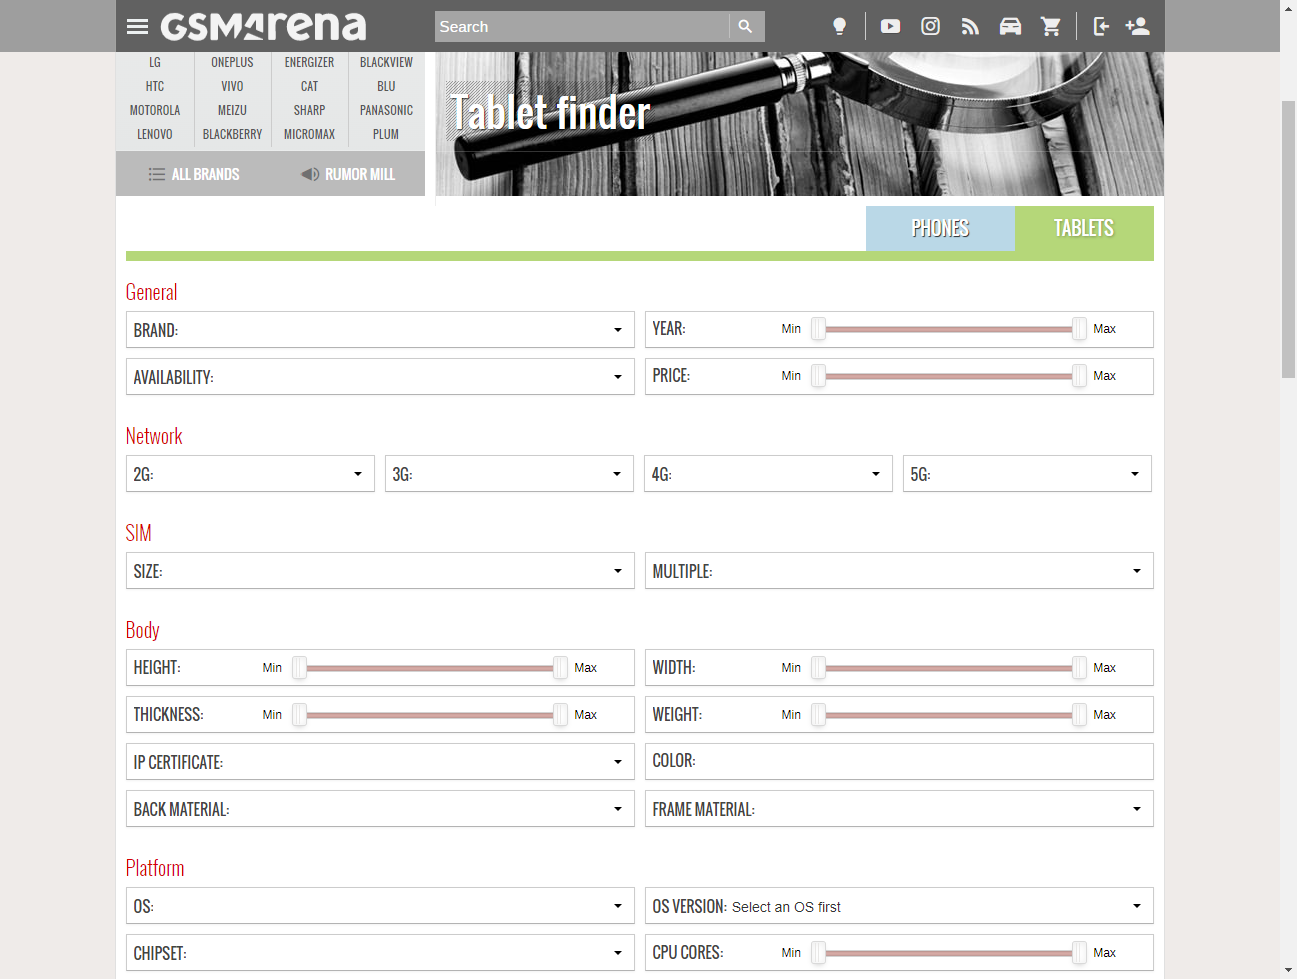

We then iterate through all the links we found and scrape the wanted data for each phone:

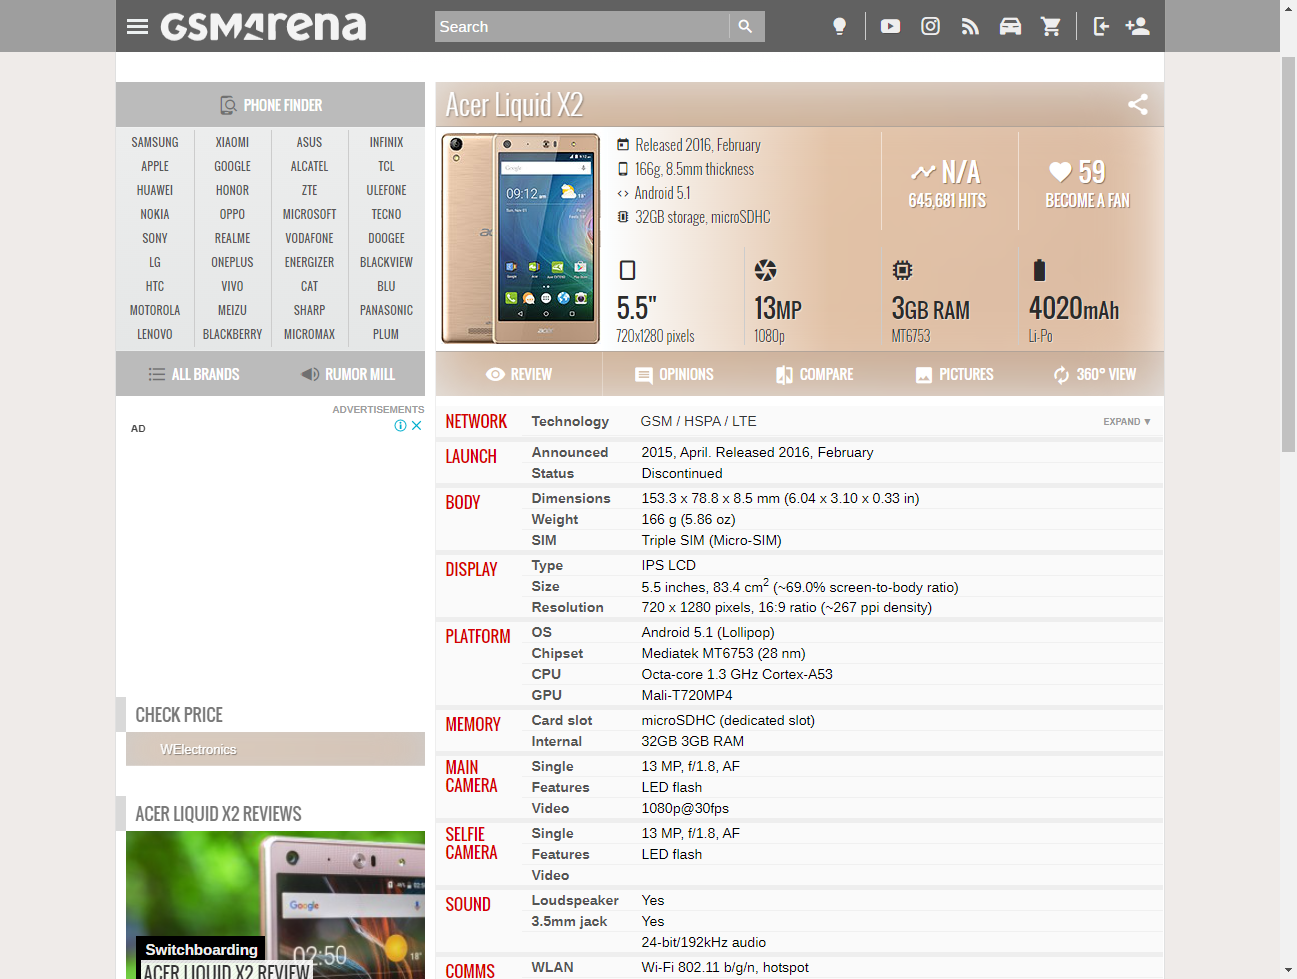

In [2]:
# disable cookies 
chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("prefs", {"profile.default_content_settings.cookies": 2})

In [3]:
def get_brands():   # get all brand names and links

    driver = webdriver.Chrome(options=chrome_options)
    driver.get('https://www.gsmarena.com/makers.php3')

    brand_menu = driver.find_element(By.CLASS_NAME, 'st-text')
    brand_list = brand_menu.find_elements(By.TAG_NAME, 'a')
    
    brands_dict = {}
    
    for a in brand_list:
        # get brand name and link
        brands_dict[a.text.split('\n')[0]] = a.get_attribute('href')

    driver.quit()
    json.dump(brands_dict, open('Data/GSMArena_Brands_links.json', 'w')) 
    print('Got brands')
    
    return brands_dict

    
def get_tablets_and_watches():   # use sites "phone finder" to get all links to tabltes and watches 
    exclude_links = []
    
    # use sites "phone finder" to get links to all tablets
    for year in range(2009, 2023):
        driver = webdriver.Chrome(options=chrome_options)
        driver.get('https://www.gsmarena.com/results.php3?mode=tablet&nYearMin='+str(year)+'&nYearMax='+str(year))
        
        # get all links from result page and add to list
        exclude_links += get_devices_from_page(driver, exclude_links)
        
        driver.quit()
    print('Got Tablets')
    
    # # use sites "phone finder" to get links to all watches
    years = [('2009', '2017'), ('2017', '2020'), ('2020', '2021'), ('2021', '2022')]
    for tup in years:
        driver = webdriver.Chrome(options=chrome_options)
        driver.get('https://www.gsmarena.com/results.php3?nYearMin='+tup[0]+'&nYearMax='+tup[1]+'&sFormFactors=8')
        
        # get all links from result page and add to list
        exclude_links += get_devices_from_page(driver, exclude_links)
        
        driver.quit()
    json.dump(exclude_links, open('Data/GSMArena_Exclude_links.json', 'w'))
    print('Got Watches')
    
    return exclude_links
    
    
def get_devices_from_page(driver, exclude_links):   # get links to all devices from page
    devices_links = []
    time.sleep(1)
    devices = driver.find_element(By.CLASS_NAME, 'makers').find_elements(By.TAG_NAME, 'a')

    for device in devices:
        time.sleep(0.2)
        try: # get device link
            link = device.get_attribute('href')
            if link not in exclude_links: # exclude tablets and watches
                devices_links.append(link)     
        except Exception as e:
            print('Failed to get: ', link)
            
    return devices_links
    
    
def get_devices(brands_dict, exclude_links):   # get links to all devices 
    devices_dict = {}
    
    for brand_name, link in brand_dict.items():

        driver = webdriver.Chrome(options=chrome_options)
        driver.get(link)

        working = True
        brand_devices = []

        while working: # succesfuly moved to next page
            time.sleep(2)
            brand_devices += get_devices_from_page(driver, exclude_links)
            try: # move to next page
                driver.find_element(By.CSS_SELECTOR, 'a.pages-next').click()
                working = True
            except: # no more pages
                working = False

        driver.quit()
        if len(brand_devices) > 0:
            all_devices[brand_name] = brand_devices
        print('Got '+brand_name+' devices')
        
    json.dump(devices_dict, open('Data/GSMArena_Devices_links.json', 'w')) 
    print('Got devices')
    
    return devices_dict

    
def get_specs(devices_dict):   # get all wanted data for each device and save to csv
    data_specs = ['year', 'dimensions', 'weight', 'displaysize', 'displayresolution', 'memoryslot', 'internalmemory',
                    'cam1modules', 'cam2modules', 'bluetooth', 'batdescription1', 'price']
    for brand_name, links in devices_dict.items(): # for each brand

        time.sleep(5)

        brand_specs = []

        for link in links: # get datd for device
            specs_dict = {}

            time.sleep(1)

            driver = webdriver.Chrome(options=chrome_options)
            driver.get(link)

            specs_dict['Name'] = driver.find_element(By.XPATH, '//*[@id="body"]/div/div[1]/div/div[1]/h1').text
            specs_dict['Brand'] = brand_name
            specs_dict['Hits'] = int(driver.find_element(By.XPATH, '//*[@id="body"]/div/div[1]/div/div[2]/ul/li[2]/span').text.split(' ')[0].replace(',', ''))
            specs_dict['Fans'] = int(driver.find_element(By.XPATH, '//*[@id="body"]/div/div[1]/div/div[2]/ul/li[3]/a/strong').text)

            for data_spec in data_specs:
                try: 
                    specs_dict[data_spec] = driver.find_element(By.CSS_SELECTOR, 'td[data-spec='+data_spec+']').text
                except:
                    specs_dict[data_spec] = np.nan


            driver.quit()       
            brand_specs.append(specs_dict)

        # save data for all devices of brand to csv 
        df =  pd.DataFrame(brand_specs)
        df.to_csv(f'Data/Devices_data/GSMArena_{brand_name}_data_.csv', index = False)
        print('Saved '+brand_name+' data')
       
    
def combine_csvs():
    # Create list of dataframes from csv files
    files = []
    devices_dict = json.load(open('Data/GSMArena_Devices_links.json'))
    for brand in devices_dict:
        files.append(pd.read_csv(f'Data/Devices_data/GSMArena_{brand}_data.csv'))
    
    # Combine all dataframes
    df = pd.concat(files, ignore_index = True)
    df.to_csv('Data/GSMArena_Data.csv', index=False)
    print('Combined and saved all data')
    
    return df


In [4]:
print("Start scraping")
#brands_dict = get_brands()
#exclude_links = get_tablets_and_watches()
#devices_dict = get_devices(brands_dict, exclude_links)
#get_specs(devices_dict)
print ('Done scraping')
#df = combine_csvs()

Start scraping
Done scraping


In [5]:
df = pd.read_csv('Data/GSMArena_Data.csv')
df

Name Brand    Hits  Fans  \
0        Acer Liquid Z6 Plus  ACER  711557    45   
1             Acer Liquid Z6  ACER  284639     4   
2             Acer Liquid X2  ACER  643626    59   
3         Acer Liquid Jade 2  ACER  374191    29   
4      Acer Liquid Zest Plus  ACER  483085    19   
...                      ...   ...     ...   ...   
11136               ZTE F101   ZTE  129999    10   
11137               ZTE F100   ZTE  125608     8   
11138    ZTE Coral200 Sollar   ZTE  110807    10   
11139          ZTE Blade V20   ZTE   89295     7   
11140         ZTE nubia X 5G   ZTE  227496    39   

                                        year  \
0      2016, August. Released 2016, December   
1      2016, August. Released 2016, December   
2       2015, April. Released 2016, February   
3                             2016, February   
4           2016, April. Released 2016, July   
...                                      ...   
11136                    2009. Released 2009   
11137                    2009. Released 2009   
11138               2007, May. Released 2007   
11139                      Not announced yet   
11140                      Not announced yet   

                                          dimensions           weight  \
0      153.8 x 75.6 x 8.5 mm (6.06 x 2.98 x 0.33 in)  169 g (5.96 oz)   
1      145.5 x 72.5 x 8.5 mm (5.73 x 2.85 x 0.33 in)  126 g (4.44 oz)   
2      153.3 x 78.8 x 8.5 mm (6.04 x 3.10 x 0.33 in)  166 g (5.86 oz)   
3      156.6 x 75.9 x 8.4 mm (6.17 x 2.99 x 0.33 in)  150 g (5.29 oz)   
4           154 x 77 x 10 mm (6.06 x 3.03 x 0.39 in)                -   
...                                              ...              ...   
11136     105 x 46 x 12.6 mm (4.13 x 1.81 x 0.50 in)   90 g (3.17 oz)   
11137     105 x 46 x 12.6 mm (4.13 x 1.81 x 0.50 in)   90 g (3.17 oz)   
11138   106 x 45.6 x 18.1 mm (4.17 x 1.80 x 0.71 in)   85 g (3.00 oz)   
11139                                              -                -   
11140                                              -                -   

                                             displaysize  \
0      5.5 inches, 83.4 cm2 (~71.7% screen-to-body ra...   
1      5.0 inches, 68.9 cm2 (~65.3% screen-to-body ra...   
2      5.5 inches, 83.4 cm2 (~69.0% screen-to-body ra...   
3      5.5 inches, 83.4 cm2 (~70.2% screen-to-body ra...   
4      5.5 inches, 83.4 cm2 (~70.3% screen-to-body ra...   
...                                                  ...   
11136  2.0 inches, 12.6 cm2 (~26.1% screen-to-body ra...   
11137  2.0 inches, 12.6 cm2 (~26.1% screen-to-body ra...   
11138                                                NaN   
11139                               6.1 inches, 91.3 cm2   
11140                              6.26 inches, 97.8 cm2   

                                       displayresolution  \
0      1080 x 1920 pixels, 16:9 ratio (~401 ppi density)   
1       720 x 1280 pixels, 16:9 ratio (~294 ppi density)   
2       720 x 1280 pixels, 16:9 ratio (~267 ppi density)   
3      1080 x 1920 pixels, 16:9 ratio (~401 ppi density)   
4       720 x 1280 pixels, 16:9 ratio (~267 ppi density)   
...                                                  ...   
11136                176 x 220 pixels (~141 ppi density)   
11137                176 x 220 pixels (~141 ppi density)   
11138                        128 x 128 pixels, 1:1 ratio   
11139  720 x 1560 pixels, 19.5:9 ratio (~282 ppi dens...   
11140  1080 x 2280 pixels, 19:9 ratio (~403 ppi density)   

                             memoryslot  \
0      microSDXC (uses shared SIM slot)   
1                             microSDXC   
2            microSDHC (dedicated slot)   
3                             microSDXC   
4            microSDXC (dedicated slot)   
...                                 ...   
11136        microSDHC (dedicated slot)   
11137        microSDHC (dedicated slot)   
11138                                No   
11139                         microSDXC   
11140                         

In [6]:
def print_df_info(df):
    print('Shape: '+str(df.shape)+'\n')
    print('Total values: '+ '{:,}'.format(df.size) +'\n')
    if df.isna().sum().sum() > 0:
        print('Null values:\n')
        print(str(df.isna().sum()) +'\n')
    print('Total Null values: '+'{:,}'.format(df.isna().sum().sum()))

In [7]:
print_df_info(df)

Shape: (11141, 16)

Total values: 178,256

Null values:

Name                    0
Brand                   0
Hits                    0
Fans                    0
year                   14
dimensions             19
weight                 91
displaysize          1209
displayresolution      47
memoryslot              0
internalmemory       1738
cam1modules             2
cam2modules          1192
bluetooth               2
batdescription1         4
price                3885
dtype: int64

Total Null values: 8,203


### <a class="anchor" id="Gettingbrandcountries"></a> Getting brand countries

We now scrape the table of "brand - country" from https://gsmfind.com/brands

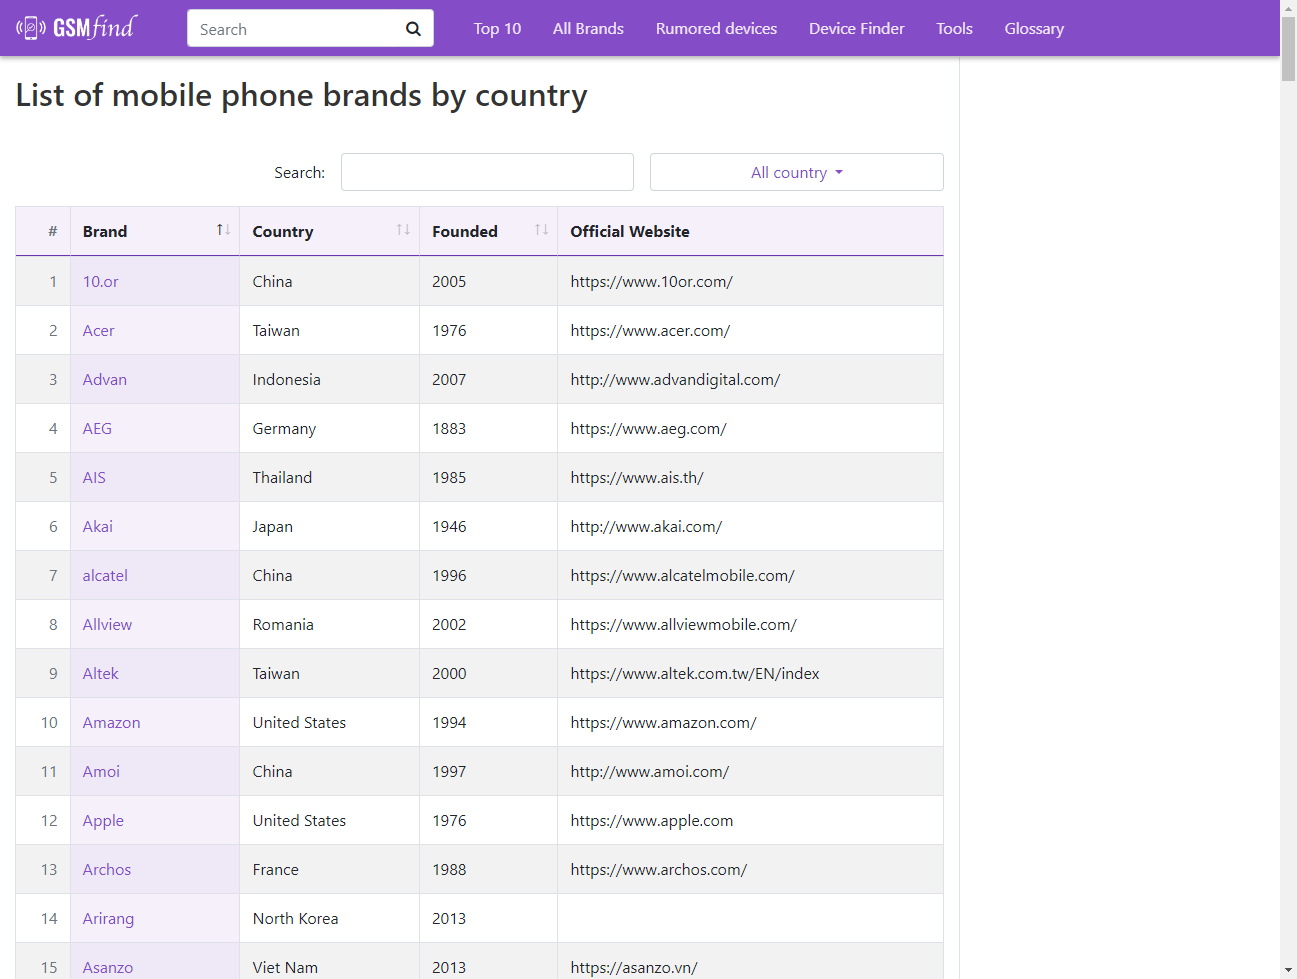

In [8]:
# Sending a request for the site
response=requests.get('https://gsmfind.com/brands')

# Geting the tables
soup = BeautifulSoup(response.text, 'html.parser')
tables = soup.find_all('table',{'id':"brand_table"})

# Creating a dataframe from the wanted table
df_country = pd.DataFrame(pd.read_html(str(tables))[0])

df_country = df_country[['Brand', 'Country']]
df_country['Brand'] = df_country['Brand'].str.upper()

df_country

Brand    Country
0    10.OR      China
1     ACER     Taiwan
2    ADVAN  Indonesia
3      AEG    Germany
4      AIS   Thailand
..     ...        ...
273  ZONDA     Mexico
274   ZOPO      China
275    ZTE      China
276    ZUK      China
277  ZYREX  Indonesia

[278 rows x 2 columns]

### <a class="anchor" id="GettingUSDexchangerates"></a> Getting USD exchange rates

We also need to get currency exchange rates to convert phone prices to one currency (I chose USD).

We get the rates from exchangerate.host api.

In [9]:
# Sending a request
url = 'https://api.exchangerate.host/latest?base=USD&symbols=USD,INR,GBP,EUR,IDR'
response = requests.get(url)

#converting the response to json
data = response.json()

# Getting the rates
USD_exchange_rates = data['rates']
USD_exchange_rates

{'EUR': 0.935777,
 'GBP': 0.828835,
 'IDR': 15182.899065,
 'INR': 82.467123,
 'USD': 1}

# <a class="anchor" id="DataCleaning"></a> Data Cleaning


**sources/credits:**
- https://pandas.pydata.org/docs/user_guide/text.html
- https://docs.python.org/3/library/re.html
- https://datascienceparichay.com/article/split-pandas-column-of-lists-into-multiple-columns/
- https://stackoverflow.com/questions/62899860/how-can-i-resolve-typeerror-cannot-safely-cast-non-equivalent-float64-to-int6
- https://stackoverflow.com/questions/25170209/python-regex-for-float-or-int-while-not-splitting-the-float-into-two-floats
- https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-the-bar-on-each-bar-with-pyplot-barh

### <a class="anchor" id="Extractingnumericdata"></a> Extracting numeric data

We need to extract all the actual numeric data from the text we scraped from GSMArena.

To do this we will use regular expressions.

In [10]:
df_extracted =df.copy()

#dimensions -> Height, Width, Thickness (in mm)
dim = df_extracted['dimensions'].str.findall('\d+(?:\.\d+)?')
df_extracted['Height'] = dim.str[0].astype(float)
df_extracted['Width'] = dim.str[1].astype(float)
df_extracted['Thickness'] = dim.str[2].astype(float)
df_extracted.drop('dimensions', axis=1, inplace=True)

#displaysize -> display size (in inches)
df_extracted['displaysize'] = df_extracted['displaysize'].str.findall('\d+(?:\.\d+)? inches').str[0].str.split().str[0].astype(float)

#displayresolution -> resX, resY, ppi (in pixels)
df_extracted.loc[~(df_extracted['displayresolution'].str.contains(pat='pixels', na=False)), 'displayresolution'] = np.nan 
df_extracted['PPI'] = df_extracted['displayresolution'].str.findall('\d* ppi').str[0].str.split().str[0].astype(float)
res = df_extracted['displayresolution'].str.findall('\d+ x \d+').str[0].str.split()
df_extracted['ResX'] = res.str[0].astype('Int64')
df_extracted['ResY'] = res.str[2].astype('Int64')
df_extracted['PPI'].fillna((df_extracted['ResX']**2 + df_extracted['ResY']**2)**0.5 / df_extracted['displaysize'] , inplace=True) # formula for ppi
df_extracted['PPI'] = np.floor(pd.to_numeric(df_extracted['PPI'], errors='coerce')).astype('Int64')
df_extracted.drop('displayresolution', axis=1, inplace=True)

#memoryslot -> has memory card slot (Yes/No)
df_extracted['memoryslot'] = (df_extracted['memoryslot'] != 'No').astype('Int64')

#weight -> weight (in grams)
df_extracted['weight'] = df_extracted['weight'].str.findall('\d+').str[0].astype(float)

#year -> release year (or announcement year if not released yet)
df_extracted['year'] = df_extracted['year'].str.findall('\d{4}').str[-1].astype('Int64')

#cam2modules -> max front camera resolution (in MP)
df_extracted['cam2modules'] = df_extracted['cam2modules'].str.findall('\d+ MP').str[0].str.split().str[0].astype('Int64')

#cam1modules -> max main camera resolution (in MP)
df_extracted['cam1modules'] = df_extracted['cam1modules'].str.findall('\d+ MP').str[0].str.split().str[0].astype('Int64')

#bluetooth -> has bluetooth (Yes/No)
df_extracted['bluetooth'] = (df_extracted['bluetooth'] != 'No').astype('Int64')

#price -> price (in USD)
df_extracted['price'] = df_extracted['price'].str.findall('[p\$₹£€]\u2009\d+,*\d*,?\d*\?*\d*|\d+ \w+').str[0].str.split()
df_extracted.loc[(df_extracted['price'].str[0].str.isdigit()) ^ (df_extracted['price'] == np.nan), 'price'] = df_extracted['price'].str[::-1]
df_extracted['currency'] = df_extracted['price'].str[0].str.replace('$', 'USD', regex=False).str.replace('₹', 'INR').str.replace('£', 'GBP').str.replace('€', 'EUR').str.replace('p', 'IDR')
df_extracted['price'] = df_extracted['price'].str[1].str.replace(',', '').astype(float)
df_extracted['price'] = round(df_extracted['price']/df_extracted['currency'].map(USD_exchange_rates)).astype('Int64') # convert to USD
df_extracted.drop('currency', axis=1, inplace=True)

#batdescription1 -> battery capacity (in mAh)
df_extracted['batdescription1'] = df_extracted['batdescription1'].str.findall('\d+,*\d* mAh').str[0].str.replace(',', '').str.split().str[0].astype('Int64')

#internalmemory -> max internal memory (in KB), max ram (in KB)
df_extracted['Max_storage'] = df_extracted['internalmemory'].str.findall('\d+ ?[MGKmgk][Bb](?! RAM)').str[-1]
df_extracted.loc[df_extracted['Max_storage'].str[-2].str.upper() == 'M', 'Max_storage'] = df_extracted['Max_storage'].str.findall('\d+').str[0].astype('Int64') * 1000
df_extracted.loc[df_extracted['Max_storage'].str[-2].str.upper() == 'G', 'Max_storage'] = df_extracted['Max_storage'].str.findall('\d+').str[0].astype('Int64') * 1000000
df_extracted.loc[df_extracted['Max_storage'].str[-2].str.upper() == 'K', 'Max_storage'] = df_extracted['Max_storage'].str.findall('\d+').str[0].astype('Int64') 
df_extracted['Max_storage'] = df_extracted['Max_storage'].astype('Int64')
df_extracted['Max_ram'] = df_extracted['internalmemory'].str.findall('\d+ ?[MGKmgk][Bb] RAM').str[-1].str.split('R').str[0].str.strip()
df_extracted.loc[df_extracted['Max_ram'].str[-2].str.upper() == 'M', 'Max_ram'] = df_extracted['Max_ram'].str.findall('\d+(?:\.\d+)?').str[0].astype('Int64') * 1000
df_extracted.loc[df_extracted['Max_ram'].str[-2].str.upper() == 'G', 'Max_ram'] = df_extracted['Max_ram'].str.findall('\d+(?:\.\d+)?').str[0].astype('Int64') * 1000000
df_extracted.loc[df_extracted['Max_ram'].str[-2].str.upper() == 'K', 'Max_ram'] = df_extracted['Max_ram'].str.findall('\d+(?:\.\d+)?').str[0].astype('Int64')
df_extracted['Max_ram'] = df_extracted['Max_ram'].astype('Int64')
df_extracted.drop('internalmemory', axis=1, inplace=True)

# Rename columns
df_extracted.rename(columns={'displaysize':'Display_size', 'memoryslot':'Card_slot', 'cam1modules':'Main_cam', 'cam2modules':'Front_cam',
                             'batdescription1':'Battery_cap', 'bluetooth':'Bluetooth', 'weight':'Weight', 'year':'Year', 'price':'Price'}, inplace=True)

df_extracted 

Name Brand    Hits  Fans  Year  Weight  Display_size  \
0        Acer Liquid Z6 Plus  ACER  711557    45  2016   169.0          5.50   
1             Acer Liquid Z6  ACER  284639     4  2016   126.0          5.00   
2             Acer Liquid X2  ACER  643626    59  2016   166.0          5.50   
3         Acer Liquid Jade 2  ACER  374191    29  2016   150.0          5.50   
4      Acer Liquid Zest Plus  ACER  483085    19  2016     NaN          5.50   
...                      ...   ...     ...   ...   ...     ...           ...   
11136               ZTE F101   ZTE  129999    10  2009    90.0          2.00   
11137               ZTE F100   ZTE  125608     8  2009    90.0          2.00   
11138    ZTE Coral200 Sollar   ZTE  110807    10  2007    85.0           NaN   
11139          ZTE Blade V20   ZTE   89295     7  <NA>     NaN          6.10   
11140         ZTE nubia X 5G   ZTE  227496    39  <NA>     NaN          6.26   

       Card_slot  Main_cam  Front_cam  ...  Battery_cap  Price  Height  Width  \
0              1        13          5  ...         4080    267   153.8   75.6   
1              1         8          2  ...         2000    128   145.5   72.5   
2              1        13         13  ...         4020    246   153.3   78.8   
3              1        21          8  ...         3000   <NA>   156.6   75.9   
4              1        13          5  ...         5000    214   154.0   77.0   
...          ...       ...        ...  ...          ...    ...     ...    ...   
11136          1         2       <NA>  ...         1000   <NA>   105.0   46.0   
11137          1         2       <NA>  ...         1000   <NA>   105.0   46.0   
11138          0      <NA>       <NA>  ...          690   <NA>   106.0   45.6   
11139          1        16          5  ...         5000   <NA>     NaN    NaN   
11140          0        16       <NA>  ...         3800   <NA>     NaN    NaN   

       Thickness   PPI  ResX  ResY  Max_storage  Max_ram  
0            8.5   401  1080  1920     32000000  3000000  
1            8.5   294   720  1280      8000000  1000000  
2            8.5   267   720  1280     32000000  3000000  
3            8.4   401  1080  1920     32000000  3000000  
4           10.0   267   720  1280     16000000  2000000  
...          ...   ...   ...   ...          ...      ...  
11136       12.6   141   176   220         <NA>     <NA>  
11137       12.6   141   176   220         <NA>     <NA>  
11138       18.1  <NA>   128   128         4000     <NA>  
11139        NaN   282   720  1560     64000000  4000000  
11140        NaN   403  1080  2280    512000000  8000000  

[11141 rows x 21 columns]

In [11]:
print_df_info(df_extracted)

Shape: (11141, 21)

Total values: 233,961

Null values:

Name               0
Brand              0
Hits               0
Fans               0
Year              96
Weight           960
Display_size    1227
Card_slot          0
Main_cam        2152
Front_cam       5936
Bluetooth          0
Battery_cap      858
Price           3886
Height           317
Width            349
Thickness        355
PPI             1262
ResX             226
ResY             226
Max_storage     1811
Max_ram         3999
dtype: int64

Total Null values: 23,660


In [12]:
df_extracted.dtypes

Name             object
Brand            object
Hits              int64
Fans              int64
Year              Int64
Weight          float64
Display_size    float64
Card_slot         Int64
Main_cam          Int64
Front_cam         Int64
Bluetooth         Int64
Battery_cap       Int64
Price             Int64
Height          float64
Width           float64
Thickness       float64
PPI               Int64
ResX              Int64
ResY              Int64
Max_storage       Int64
Max_ram           Int64
dtype: object

### <a class="anchor" id="Addingcountrycolumn"></a> Adding country column

We also need to add the countries we got from https://gsmfind.com/brands.

In [13]:
# Adding country column
df_extracted = pd.merge(df_extracted, df_country, how='inner', on='Brand')

# Reordering columns
df_extracted = df_extracted[['Name', 'Brand', 'Country', 'Year', 'Weight', 'Height', 'Width', 'Thickness', 'Display_size', 'ResX', 'ResY', 'PPI',
                            'Main_cam', 'Front_cam', 'Bluetooth', 'Card_slot', 'Max_storage', 'Max_ram', 'Battery_cap', 'Price', 'Hits', 'Fans']]

df_extracted

Name Brand Country  Year  Weight  Height  Width  \
0        Acer Liquid Z6 Plus  ACER  Taiwan  2016   169.0   153.8   75.6   
1             Acer Liquid Z6  ACER  Taiwan  2016   126.0   145.5   72.5   
2             Acer Liquid X2  ACER  Taiwan  2016   166.0   153.3   78.8   
3         Acer Liquid Jade 2  ACER  Taiwan  2016   150.0   156.6   75.9   
4      Acer Liquid Zest Plus  ACER  Taiwan  2016     NaN   154.0   77.0   
...                      ...   ...     ...   ...     ...     ...    ...   
11136               ZTE F101   ZTE   China  2009    90.0   105.0   46.0   
11137               ZTE F100   ZTE   China  2009    90.0   105.0   46.0   
11138    ZTE Coral200 Sollar   ZTE   China  2007    85.0   106.0   45.6   
11139          ZTE Blade V20   ZTE   China  <NA>     NaN     NaN    NaN   
11140         ZTE nubia X 5G   ZTE   China  <NA>     NaN     NaN    NaN   

       Thickness  Display_size  ResX  ...  Main_cam  Front_cam  Bluetooth  \
0            8.5          5.50  1080  ...        13          5          1   
1            8.5          5.00   720  ...         8          2          1   
2            8.5          5.50   720  ...        13         13          1   
3            8.4          5.50  1080  ...        21          8          1   
4           10.0          5.50   720  ...        13          5          1   
...          ...           ...   ...  ...       ...        ...        ...   
11136       12.6          2.00   176  ...         2       <NA>          1   
11137       12.6          2.00   176  ...         2       <NA>          1   
11138       18.1           NaN   128  ...      <NA>       <NA>          0   
11139        NaN          6.10   720  ...        16          5          1   
11140        NaN          6.26  1080  ...        16       <NA>          1   

       Card_slot  Max_storage  Max_ram  Battery_cap  Price    Hits  Fans  
0              1     32000000  3000000         4080    267  711557    45  
1              1      8000000  1000000         2000    128  284639     4  
2              1     32000000  3000000         4020    246  643626    59  
3              1     32000000  3000000         3000   <NA>  374191    29  
4              1     16000000  2000000         5000    214  483085    19  
...          ...          ...      ...          ...    ...     ...   ...  
11136          1         <NA>     <NA>         1000   <NA>  129999    10  
11137          1         <NA>     <NA>         1000   <NA>  125608     8  
11138          0         4000     <NA>          690   <NA>  110807    10  
11139          1     64000000  4000000         5000   <NA>   89295     7  
11140          0    512000000  8000000         3800   <NA>  227496    39  

[11141 rows x 22 columns]

In [14]:
print_df_info(df_extracted)

Shape: (11141, 22)

Total values: 245,102

Null values:

Name               0
Brand              0
Country            0
Year              96
Weight           960
Height           317
Width            349
Thickness        355
Display_size    1227
ResX             226
ResY             226
PPI             1262
Main_cam        2152
Front_cam       5936
Bluetooth          0
Card_slot          0
Max_storage     1811
Max_ram         3999
Battery_cap      858
Price           3886
Hits               0
Fans               0
dtype: int64

Total Null values: 23,660


In [15]:
df_extracted.describe()

Year        Weight        Height         Width     Thickness  \
count  11045.000000  10181.000000  10824.000000  10792.000000  10786.000000   
mean    2012.833952    141.224634    129.805127     63.817643     12.576515   
std        5.722322     54.504205     27.642349     15.307729      5.081081   
min     1994.000000      0.000000      5.100000      8.000000      0.000000   
25%     2009.000000    100.000000    107.500000     50.000000      8.700000   
50%     2013.000000    137.000000    129.000000     65.500000     10.700000   
75%     2017.000000    172.000000    154.000000     74.500000     15.000000   
max     2022.000000    800.000000    260.900000    256.800000     75.000000   

       Display_size          ResX          ResY          PPI     Main_cam  \
count   9914.000000  10915.000000  10915.000000  9879.000000  8989.000000   
mean       4.347280    550.279798   1002.032891   254.087964    15.283903   
std        1.760714    369.973140    804.189376   107.096648    18.991096   
min        1.000000     64.000000     32.000000    66.000000     1.000000   
25%        2.600000    240.000000    320.000000   167.000000     5.000000   
50%        4.640000    480.000000    800.000000   233.000000     8.000000   
75%        5.987500    720.000000   1560.000000   308.500000    15.000000   
max       10.100000   3840.000000   4320.000000   847.000000   200.000000   

         Front_cam     Bluetooth     Card_slot   Max_storage       Max_ram  \
count  5205.000000  11141.000000  11141.000000  9.330000e+03  7.142000e+03   
mean      9.427281      0.855309      0.760704  5.001699e+07  3.127478e+06   
std       8.555867      0.351805      0.426673  9.501229e+07  4.446540e+06   
min       1.000000      0.000000      0.000000  2.000000e+01  3.840000e+02   
25%       5.000000      1.000000      1.000000  1.280000e+05  7.680000e+05   
50%       8.000000      1.000000      1.000000  8.000000e+06  2.000000e+06   
75%      13.000000      1.000000      1.000000  6.400000e+07  4.000000e+06   
max      60.000000      1.000000      1.000000  6.400000e+08  2.560000e+08   

        Battery_cap        Price          Hits          Fans  
count  10283.000000  7255.000000  1.114100e+04  11141.000000  
mean    2345.152096   223.994624  1.460820e+06     67.060408  
std     1541.086424   331.156878  4.134989e+06    204.936261  
min      300.000000    11.000000  1.379000e+03      0.000000  
25%     1000.000000    96.000000  1.184210e+05      7.000000  
50%     1930.000000   160.000000  2.975580e+05     15.000000  
75%     3300.000000   267.000000  1.003661e+06     43.000000  
max    18000.000000  9618.000000  7.900006e+07   5570.000000

We now have our complete dataset.

Lets check if we have any duplicated data.

In [16]:
df_extracted.duplicated().sum()

0

We dont have any duplicated data.

We can move on to handling missing values.

### <a class="anchor" id="Handlingmissingvalues"></a> Handling missing values

In [17]:
print_df_info(df_extracted)

Shape: (11141, 22)

Total values: 245,102

Null values:

Name               0
Brand              0
Country            0
Year              96
Weight           960
Height           317
Width            349
Thickness        355
Display_size    1227
ResX             226
ResY             226
PPI             1262
Main_cam        2152
Front_cam       5936
Bluetooth          0
Card_slot          0
Max_storage     1811
Max_ram         3999
Battery_cap      858
Price           3886
Hits               0
Fans               0
dtype: int64

Total Null values: 23,660


We seem to have a lot of missing data.

Lets take a closer look.

In [18]:
def plot_missing(df):
    plt.figure(figsize=(20,10))
    
    # Create heatmap
    ax = sns.heatmap(df.isna(), yticklabels=False, cbar=False)
    
    # Rotate labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 15)
    
    # Draw vertical seperation lines
    for i in range(df.shape[1]):
        ax.axvline(i, color='white', lw=0.6)
        
    # Add title
    plt.title('Missing values (White)', fontsize = 15)
    
    plt.show()

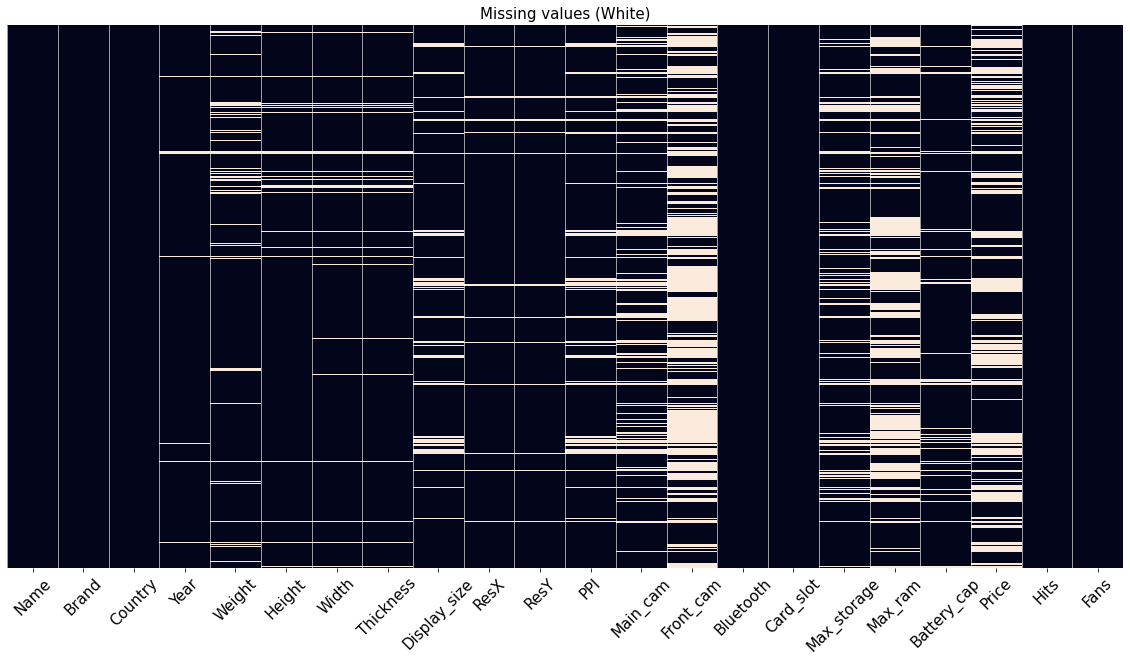

In [19]:
plot_missing(df_extracted)

#### MNAR

Lets start with values which are misssing not at random,

these values can be easily dealt with:
- No front camera = 0 MP
- No main camera = 0 MP
- No dedicated ram = 0 KB
- No release year = phones that have not yet been released (not very usefull for our purposes) can be removed

In [201]:
# Creating a copy of the dataframe
df_no_missing = df_extracted.copy()

# filling in Front camera, Main camera and Max ram columns
df_no_missing['Front_cam'].fillna(0, inplace=True)
df_no_missing['Main_cam'].fillna(0, inplace=True)
df_no_missing['Max_ram'].fillna(0, inplace=True)

# Dropping unreleased phones
df_no_missing.dropna(subset='Year',inplace=True)

df_no_missing.reset_index(drop=True, inplace=True)

In [202]:
print_df_info(df_no_missing)

Shape: (11045, 22)

Total values: 242,990

Null values:

Name               0
Brand              0
Country            0
Year               0
Weight           892
Height           262
Width            291
Thickness        297
Display_size    1217
ResX             222
ResY             222
PPI             1252
Main_cam           0
Front_cam          0
Bluetooth          0
Card_slot          0
Max_storage     1789
Max_ram            0
Battery_cap      818
Price           3801
Hits               0
Fans               0
dtype: int64

Total Null values: 11,063


More than half of the missing values have been dealt with.

Lets move on to the rest.

#### MAR & MCAR

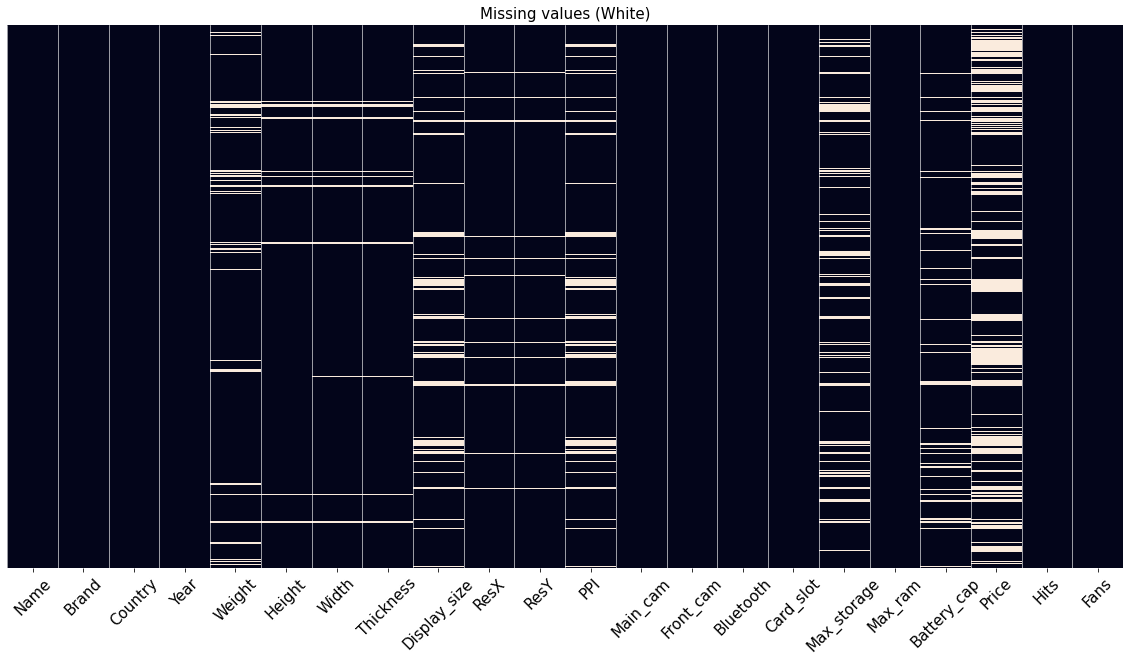

In [203]:
plot_missing(df_no_missing)

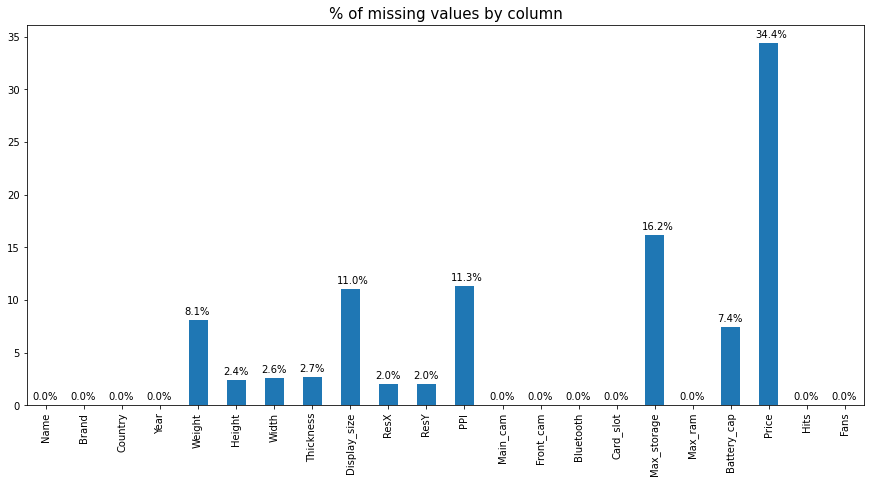

In [204]:
fig = plt.figure(figsize=(15,7))

# Create series of % of missing values for each column
df_missing = df_no_missing.isna().sum() / df_no_missing.shape[0] * 100


# Plot bar plot
df_missing.plot.bar()

# Add annotations
for i, v in enumerate(df_missing):
    plt.text(i-0.35, v+0.5, str(round(v, 1))+'%')  
plt.title('% of missing values by column', size=15)

plt.show()

The price column is missing 3,801 values which is 34.4% (more than a third) of all rows!!

thats way too much to work with, therefore, the price column will be droped.

In [205]:
df_no_missing.drop('Price', axis=1, inplace=True)

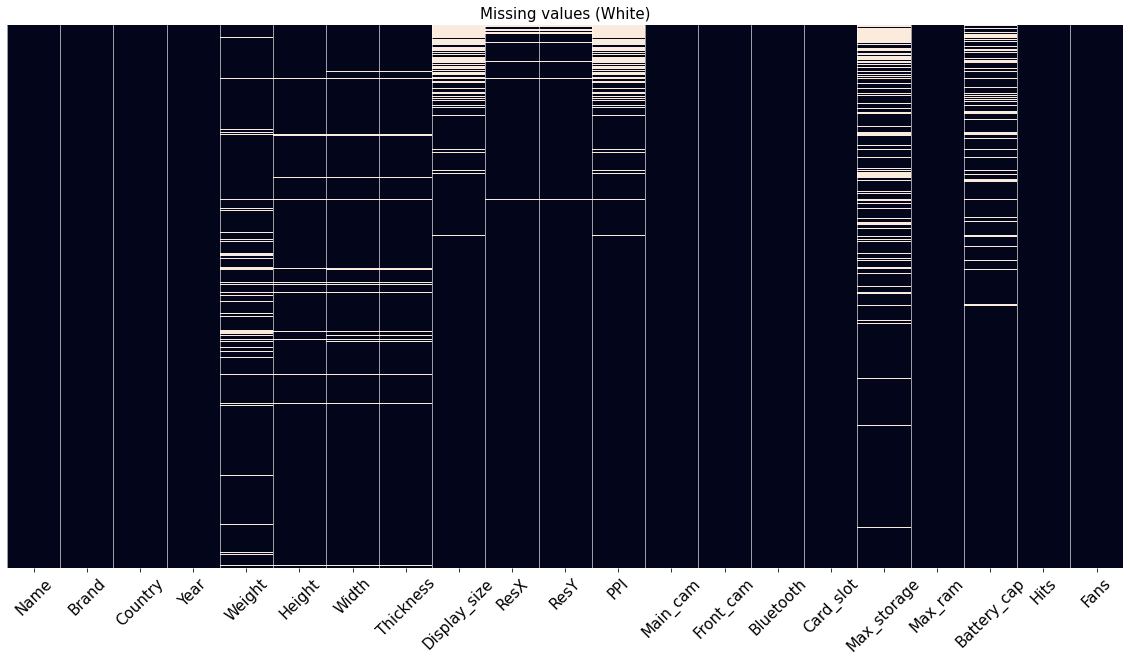

In [206]:
plot_missing(df_no_missing.sort_values('Year'))

When we sort the data by release year in ascending order we can clearly see there are more missing values for older phones.

Lets take a closer look.

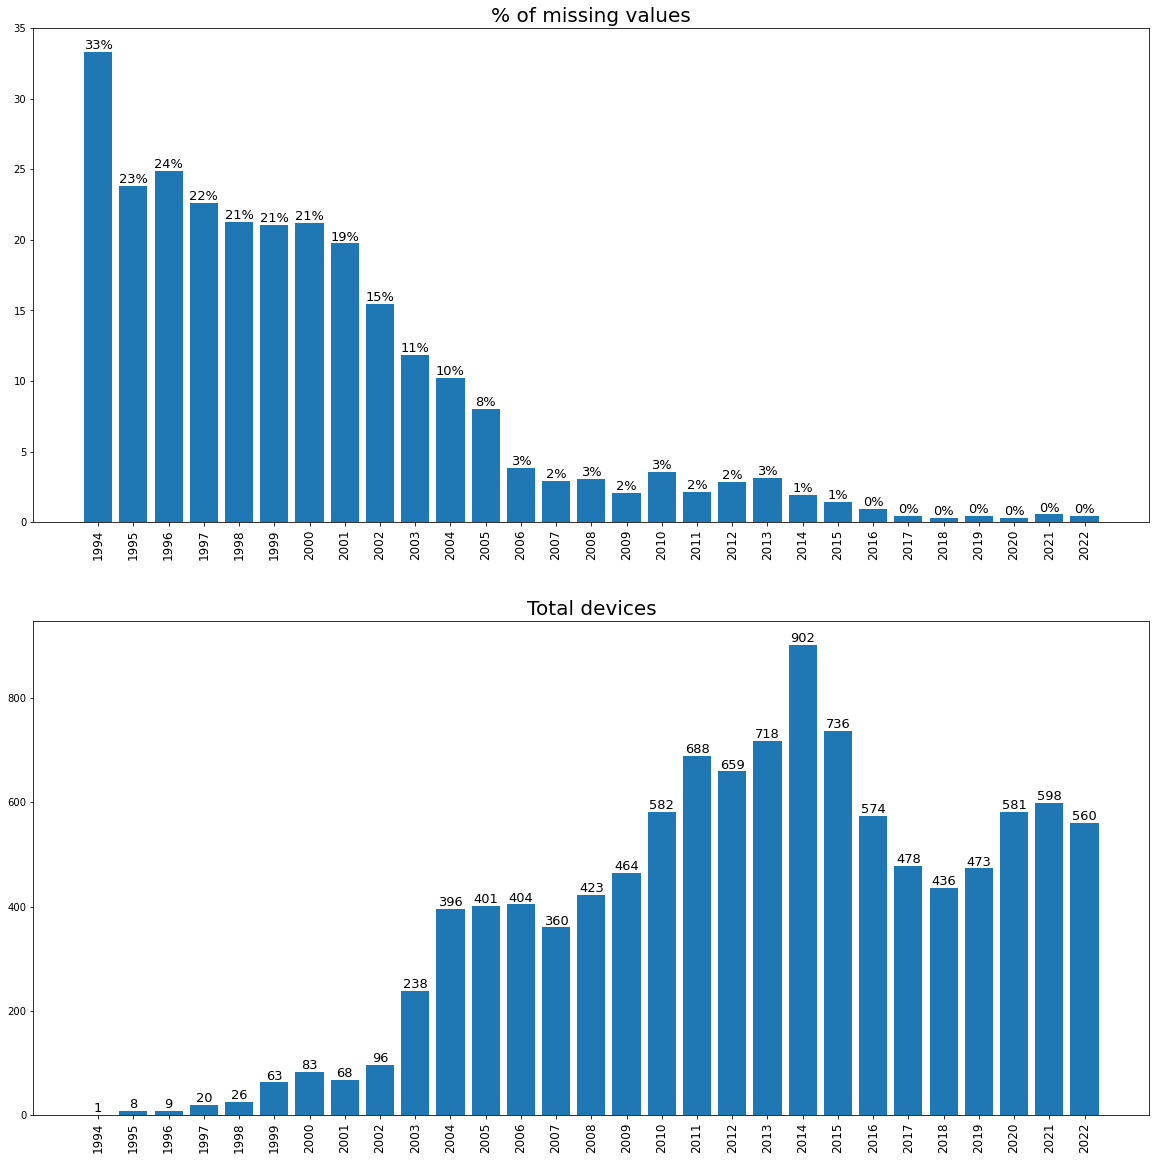

In [207]:
# Creating year - total count series
df_year = df_no_missing.groupby(df_no_missing['Year']).count()['Name']

# Creating year - missing count series
df_missing = df_no_missing.isna().groupby(df_no_missing['Year']).sum().sum(axis=1)

# Creating year -  % of missing values series
df_missing_ration = df_missing / (df_year * df_no_missing.shape[1]) * 100

# Making list of years
years = df_year.index.to_list()

# Plotting bar charts
fig, ax = plt.subplots(2, 1, figsize=(20,20))

bars = ax[0].bar(years, df_missing_ration, tick_label=years)
ax[0].bar_label(bars, fmt='%d%%', label_type='edge', fontsize=13)
ax[0].set_xticklabels(labels=years, rotation = 90, fontsize=12)
ax[0].set_title('% of missing values', size=20)

bars = ax[1].bar(years, df_year, tick_label=years)
ax[1].bar_label(bars, label_type='edge', fontsize=13)
ax[1].set_xticklabels(labels=years, rotation = 90, fontsize=12)
ax[1].set_title('Total devices', size=20)

plt.show()

In the plots above two thing that become very clear are that older phones have more misssing values and that there are not a lot of older phones

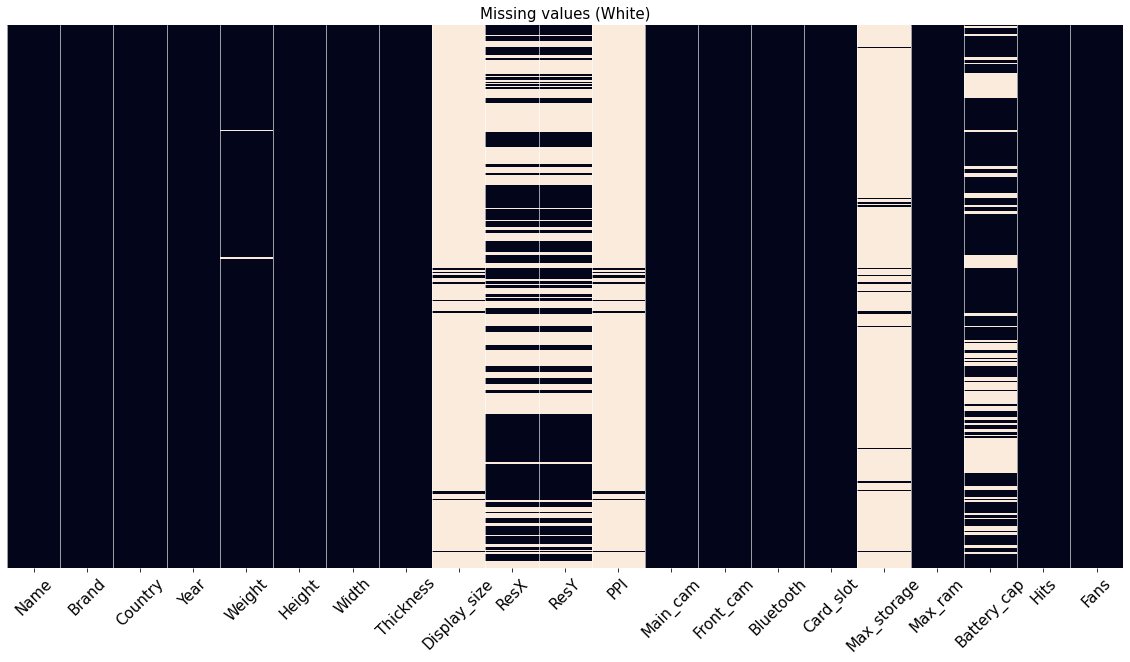

In [208]:
plot_missing(df_no_missing[df_no_missing['Year'] < 2003])

In [209]:
df_no_missing[df_no_missing['Year'] < 2003].shape[0]

374

We can also see here that for phones released before 2003 a lot of data is missing, some columns are almost completely missing.

Due to this fact along with the fact that there are only 374 phones released bofore 2003 all phones released before 2003 will be droped from the dataset.

In [210]:
print('Before: \nRows - {} \nNull values - {}'.format(df_no_missing.shape[0], df_no_missing.isna().sum().sum()))

Before: 
Rows - 11045 
Null values - 7262


In [211]:
df_no_missing = df_no_missing[df_no_missing['Year'] >= 2003]

In [212]:
print('After: \nRows - {} \nNull values - {}'.format(df_no_missing.shape[0], df_no_missing.isna().sum().sum()))

After: 
Rows - 10671 
Null values - 5714


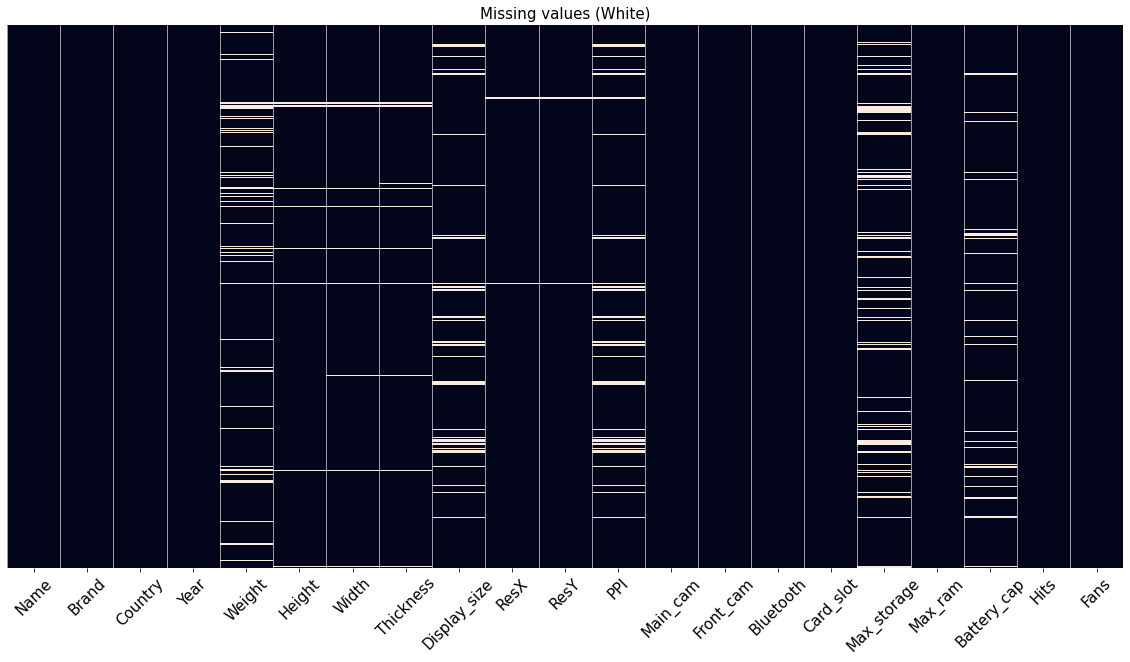

In [213]:
plot_missing(df_no_missing)

In [214]:
print_df_info(df_no_missing)

Shape: (10671, 21)

Total values: 224,091

Null values:

Name               0
Brand              0
Country            0
Year               0
Weight           890
Height           262
Width            291
Thickness        297
Display_size     855
ResX              54
ResY              54
PPI              890
Main_cam           0
Front_cam          0
Bluetooth          0
Card_slot          0
Max_storage     1430
Max_ram            0
Battery_cap      691
Hits               0
Fans               0
dtype: int64

Total Null values: 5,714


In order to minimize the amount of bias introduced to the data, before filling in the rest of the missing values, we will drop all rows containing at least 3 missing values. 

In [215]:
df_no_missing.dropna(thresh=df_no_missing.shape[1] - 3, axis=0, inplace=True)

In [216]:
print_df_info(df_no_missing)

Shape: (10248, 21)

Total values: 215,208

Null values:

Name               0
Brand              0
Country            0
Year               0
Weight           629
Height            15
Width             41
Thickness         47
Display_size     680
ResX              20
ResY              20
PPI              697
Main_cam           0
Front_cam          0
Bluetooth          0
Card_slot          0
Max_storage     1160
Max_ram            0
Battery_cap      484
Hits               0
Fans               0
dtype: int64

Total Null values: 3,793


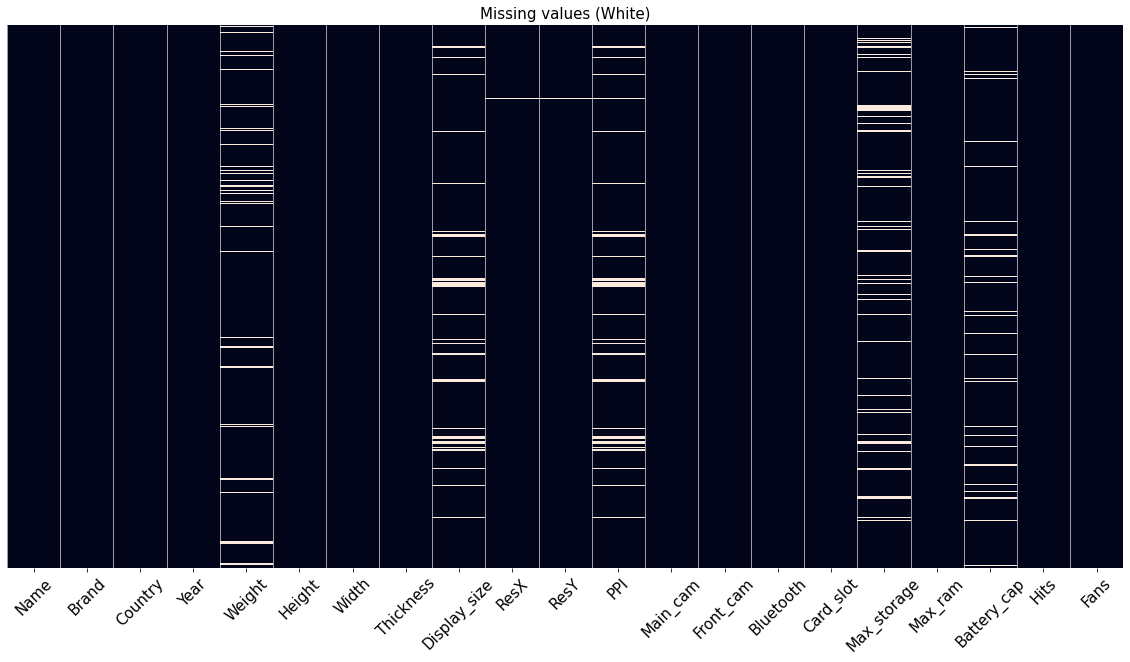

In [49]:
plot_missing(df_no_missing)

Now we can fill in the remaining missing values.

They will be filled with the median value.

the PPI column will be filled using the formula:
$$PPI=\frac{\sqrt{(ResX)^{2} + (ResY)^{2}}}{Display size}$$

In [50]:
# Making list of columns containing missing values
cols = list(df_no_missing.columns[df_no_missing.isna().any()])
cols.remove('PPI')

# Filling in missing with median
for col in cols:
    df_no_missing[col].fillna(df_no_missing[col].median(), inplace=True)

# filling in ppi column with formula
df_no_missing['PPI'].fillna(((df_no_missing['ResX']**2 + df_no_missing['ResY']**2)**0.5 / df_no_missing['Display_size']).astype('Int64') , inplace=True) # formula for ppi

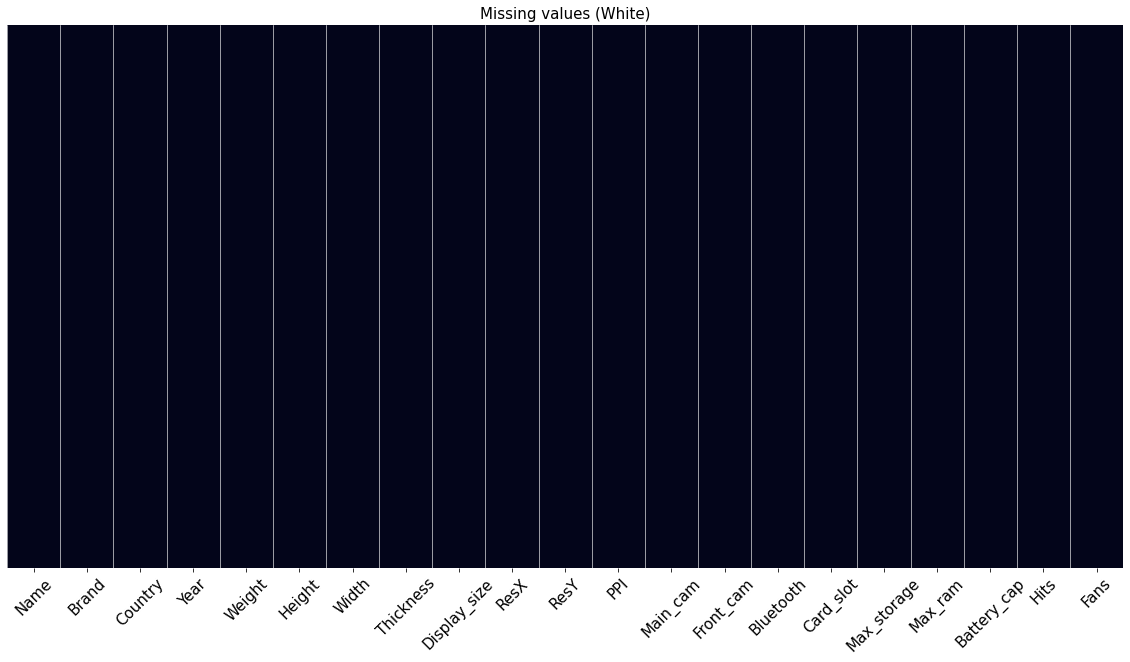

In [51]:
plot_missing(df_no_missing)

In [52]:
print_df_info(df_no_missing)

Shape: (10248, 21)

Total values: 215,208

Total Null values: 0


After dealing with missing values we are left with 10,248 phones (215,208 data points)

We dont have anymore missing data.

We can now move on to dealing with outliers.

### <a class="anchor" id="Dealingwithoutliers"></a> Dealing with outliers

In [53]:
# Making list of numeric coulmns excluding boolians
num_cols = df_no_missing._get_numeric_data().columns.to_list()
num_cols.remove('Bluetooth')
num_cols.remove('Card_slot')

In [54]:
def plot_dist(df, cols):
    
    # Plotting distributions for numeric columns
    fig, ax = plt.subplots(int(len(cols)/2), 2, figsize=(20,20))

    for i, col in enumerate(cols):
        sns.histplot(x=df[col], kde=True, ax=ax[int(i/2),i%2])
        ax[int(i/2),i%2].set_title(col, size=20)
        ax[int(i/2),i%2].set_xlabel('')

    plt.tight_layout()
    plt.show()

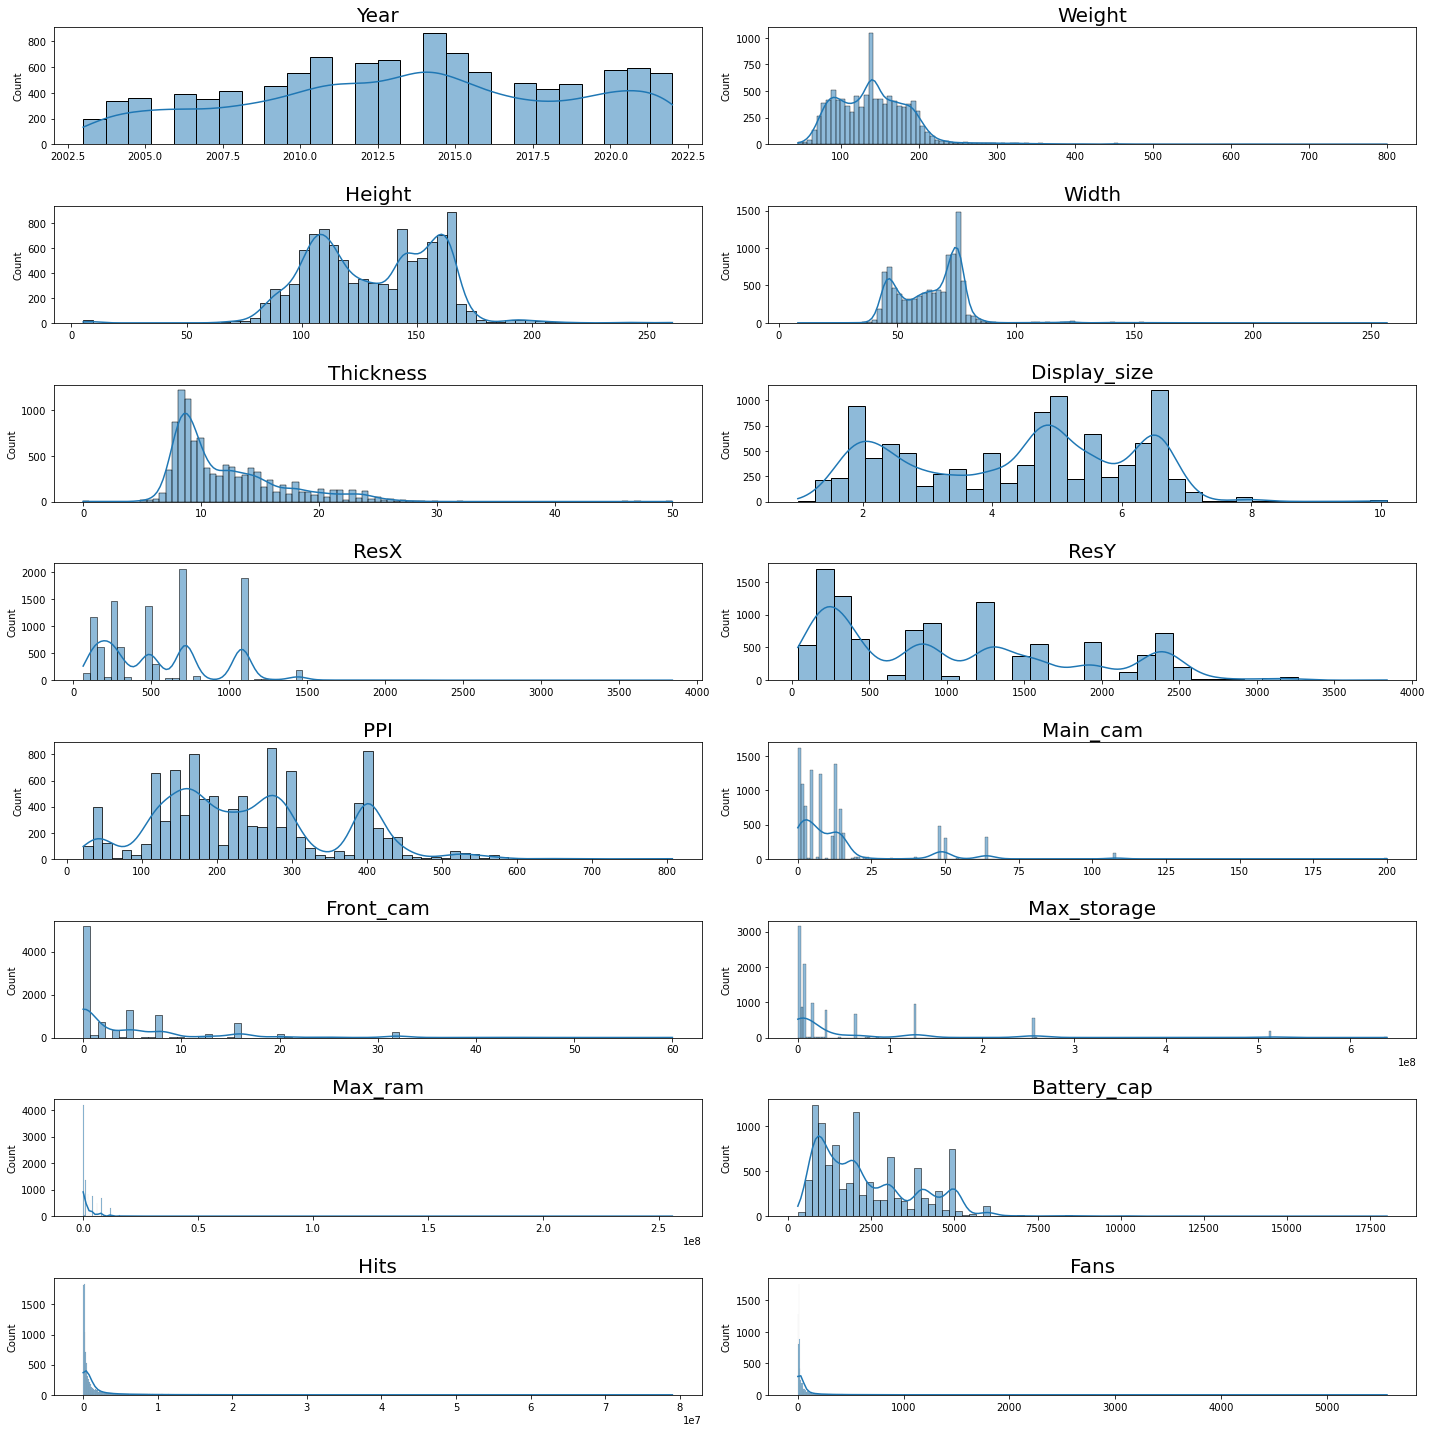

In [55]:
plot_dist(df_no_missing, num_cols)

It looks like we have some outliers to deal with

In [56]:
df_no_missing[df_no_missing['Max_ram'] == 256000000]

Name    Brand  Country  Year  Weight  Height  Width  \
592  Allview P1 AllDro  ALLVIEW  Romania  2011   119.0   115.9   62.0   

     Thickness  Display_size  ResX  ...  PPI  Main_cam  Front_cam  Bluetooth  \
592       12.9           3.5   320  ...  165         5          0          1   

     Card_slot  Max_storage    Max_ram  Battery_cap   Hits  Fans  
592          1       512000  256000000         1500  40563     2  

[1 rows x 21 columns]

256GB of ram seems like a lot for a phone...

After some investigating it seems that it is indeed a mistake, they inputed 256GB when it is suposed to be 256MB.

an easy fix.

In [57]:
df_no_missing.loc[df_no_missing['Max_ram'] == 256000000, 'Max_ram'] = 256000

It also looks like we have phones weighting over 500 grams which also seems like a lot

In [58]:
df_no_missing[df_no_missing['Width'] > 250]

Name      Brand Country  Year  Weight  \
6944  Prestigio MultiPad 10.1 Ultimate 3G  PRESTIGIO  Cyprus  2013   680.0   
6945     Prestigio MultiPad 10.1 Ultimate  PRESTIGIO  Cyprus  2013   660.0   

      Height  Width  Thickness  Display_size  ResX  ...  PPI  Main_cam  \
6944   175.0  256.8       10.2          10.1   800  ...  149         2   
6945   175.0  256.8       10.2          10.1   800  ...  149         2   

      Front_cam  Bluetooth  Card_slot  Max_storage  Max_ram  Battery_cap  \
6944          2          1          1     16000000  1000000         6400   
6945          2          1          1     16000000  1000000         6400   

       Hits  Fans  
6944  99184     4  
6945  82168     2  

[2 rows x 21 columns]

It looks like some tablets have gone through while scraping the site. we need to find a way to filter them out.

After some searching on the site i found that these perameters catch all the tablets on the site while only catching 17 phones:


display size >= 6.9 &emsp;&&emsp; height >= 175 &emsp;&&emsp; width >= 80 &emsp;&emsp;&&emsp; thickness >= 7

In [59]:
df_no_missing[(df_no_missing['Display_size'] >= 6.9)&(df_no_missing['Height'] >= 175)&(df_no_missing['Width'] >= 80)&(df_no_missing['Thickness'] >= 7)]

Name    Brand        Country  Year  Weight  \
15     Acer Iconia Tab A3-A20FHD     ACER         Taiwan  2014   508.0   
33            Acer Iconia B1-721     ACER         Taiwan  2014   323.0   
34            Acer Iconia B1-720     ACER         Taiwan  2014   315.0   
174               alcatel Pop 8S  ALCATEL          China  2014   327.0   
175               alcatel Hero 8  ALCATEL          China  2014   310.0   
...                          ...      ...            ...   ...     ...   
10585                   XOLO Tab     XOLO          India  2013   480.0   
10669             Yezz Epic T7FD     YEZZ  United States  2014   274.0   
10671             Yezz Epic T7ED     YEZZ  United States  2013   272.0   
10683               Yezz Epic T7     YEZZ  United States  2013   293.0   
10961                    ZTE V81      ZTE          China  2013   140.0   

       Height  Width  Thickness  Display_size  ResX  ...  PPI  Main_cam  \
15      256.5  170.2       10.2          10.1  1920  ...  224         5   
33      199.0  122.3       11.4           7.0   600  ...  170         0   
34      198.1  121.9       10.2           7.0   600  ...  170         0   
174     209.0  128.0        7.2           8.0   800  ...  189         5   
175     209.0  122.0        7.3           8.0  1200  ...  283         5   
...       ...    ...        ...           ...   ...  ...  ...       ...   
10585   214.2  154.9       11.3           8.0   768  ...  160         2   
10669   192.0  112.0       10.2           7.0   480  ...  133        15   
10671   186.8  106.7       11.6           7.0   600  ...  170        15   
10683   177.8  121.4       10.2           7.0   480  ...  133         2   
10961   200.0  156.0       11.1           8.0   768  ...  160         2   

       Front_cam  Bluetooth  Card_slot  Max_storage  Max_ram  Battery_cap  \
15             2          1          1     32000000  2000000         5910   
33             0          1          1     16000000  1000000         2955   
34             0          1          1     16000000  1000000         2955   
174            3          1          1      8000000  1000000         4100   
175            2          1          1     32000000  2000000         4060   
...          ...        ...        ...          ...      ...          ...   
10585          0          1          1      4000000  1000000         4000   
10669          3          1          1      4000000  1000000         2500   
10671          3          1          1      8000000  1000000         2500   
10683          0          0          1     16000000   512000         2600   
10961          0          1          1      4000000  1000000         3700   

         Hits  Fans  
15     176269     8  
33     289294     3  
34     331353     5  
174    234748     4  
175    312979    15  
...       ...   ...  
10585  193666     8  
10669   60657     3  
10671   52278     3  
10683   58056     4  
10961  122320     4  

[141 rows x 21 columns]

Lets filter them out.

In [60]:
df_no_missing = df_no_missing[~((df_no_missing['Display_size'] >= 6.9)&(df_no_missing['Height'] >= 175)&(df_no_missing['Width'] >= 80)&(df_no_missing['Thickness'] >= 7))]

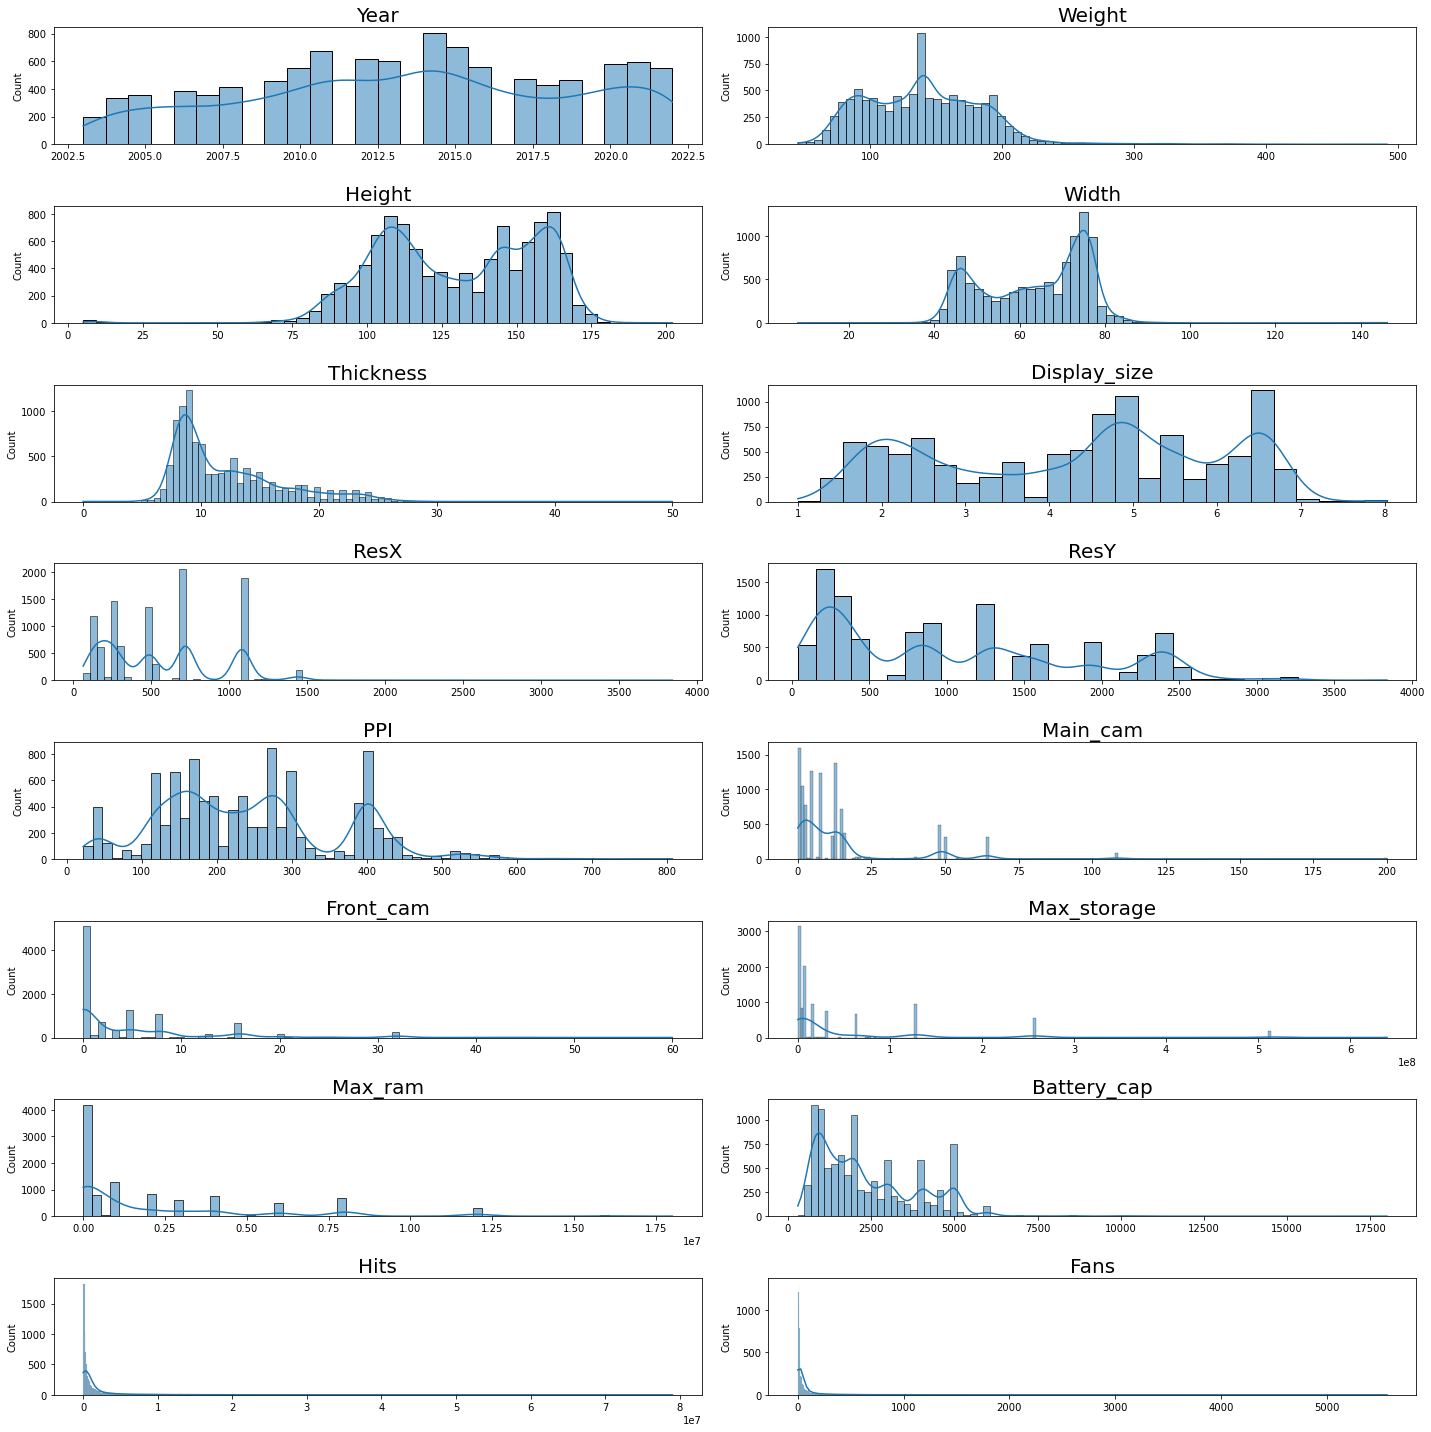

In [61]:
plot_dist(df_no_missing, num_cols)

Much better.

As for the Hits and Fans columns all outliers will be removed using the 1.5 * IQR method.

In [62]:
def plot_boxplots(df, cols):
    fig, ax = plt.subplots(2, 1, figsize=(20, 7))  

    # Create boxplot for each column
    for i, col in enumerate(cols):
        sns.boxplot(x=df[col], ax=ax[i])
        ax[i].set_title(col, size=20)
    
    plt.tight_layout()
    plt.show()

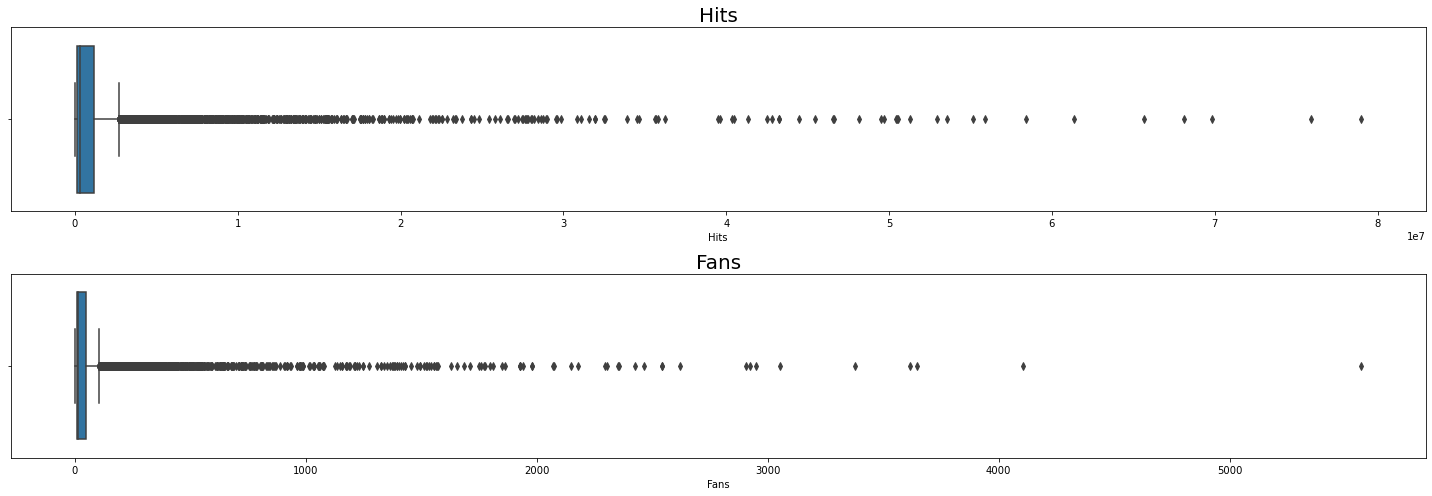

In [63]:
plot_boxplots(df_no_missing, ['Hits', 'Fans'])

In [64]:
def remove_outliers(df, cols):
    new_df = df.copy()
    for col in cols:
        Q1 = np.percentile(new_df[col], 25)
        Q3 = np.percentile(new_df[col], 75)
        IQR = Q3 - Q1
        IQR_range = 1.5 * IQR
        new_df.loc[(new_df[col] < Q1 - IQR_range) | (new_df[col] > Q3 + IQR_range) ,col] = np.nan
    return new_df.dropna()

In [65]:
df_no_outlires = remove_outliers(df_no_missing, ['Hits', 'Fans'])

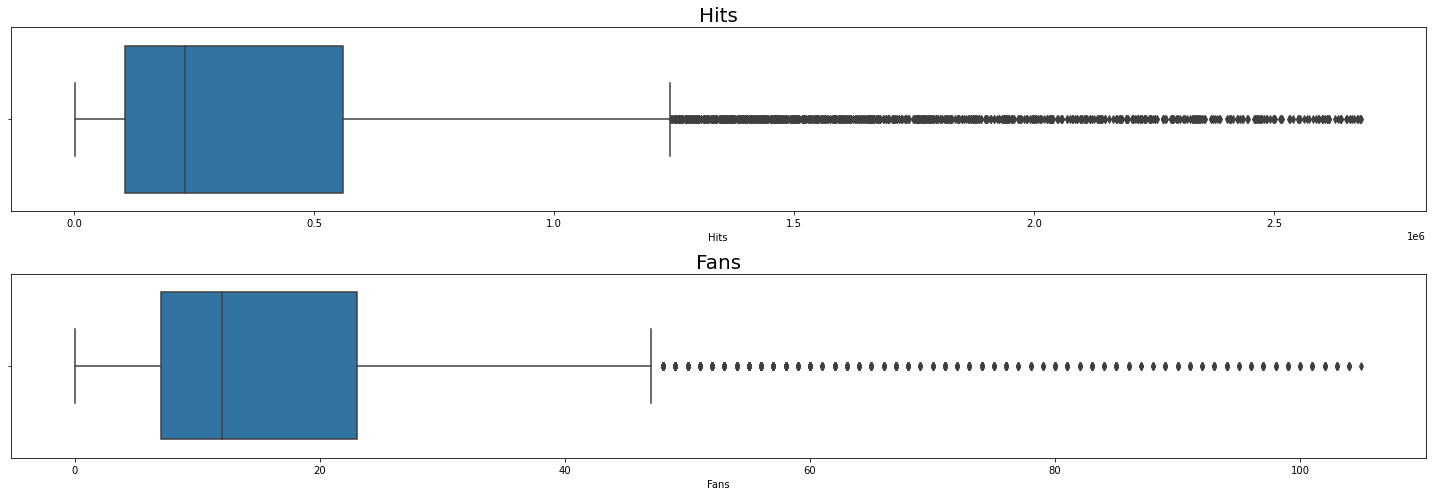

In [66]:
plot_boxplots(df_no_outlires, ['Hits', 'Fans'])

In [67]:
print_df_info(df_no_outlires)

Shape: (8266, 21)

Total values: 173,586

Total Null values: 0


After dealing with outliers we are left with 8,266 phones (173,586 data points)

# <a class="anchor" id="Eda"></a> EDA

**sources/credits:**
- https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap
- https://geopandas.org/en/stable/docs/user_guide/mapping.html

### <a class="anchor" id="CatagoricalPlots"></a> Catagorical Plots

In [68]:
def plot_discrete_avgs(df):
    fig, ax = plt.subplots(6, 1,figsize=(15, 30))

    i = 0
    for cat in ['Brand', 'Country', 'Year']:
        for num in ['Hits', 'Fans']:
            
            # Create barplot for each pair of columns
            if cat == 'Year':
                sns.barplot(ax=ax[i], x=cat, y=num, data=df,  ci=None)
            else:
                df_sorted = df.groupby([cat])[num].mean().reset_index().sort_values(num)
                sns.barplot(ax=ax[i], x=cat, y=num, data=df,  ci=None, order=df_sorted[cat])
            ax[i].set(xlabel=None)
            
            # Add title
            ax[i].set_title('Avg '+num+' by '+cat, fontsize = 20)
            
            # Rotate labels
            ax[i].tick_params(labelrotation=90, axis = 'x', labelsize=10)
            i += 1
    
    plt.tight_layout()
    plt.show()

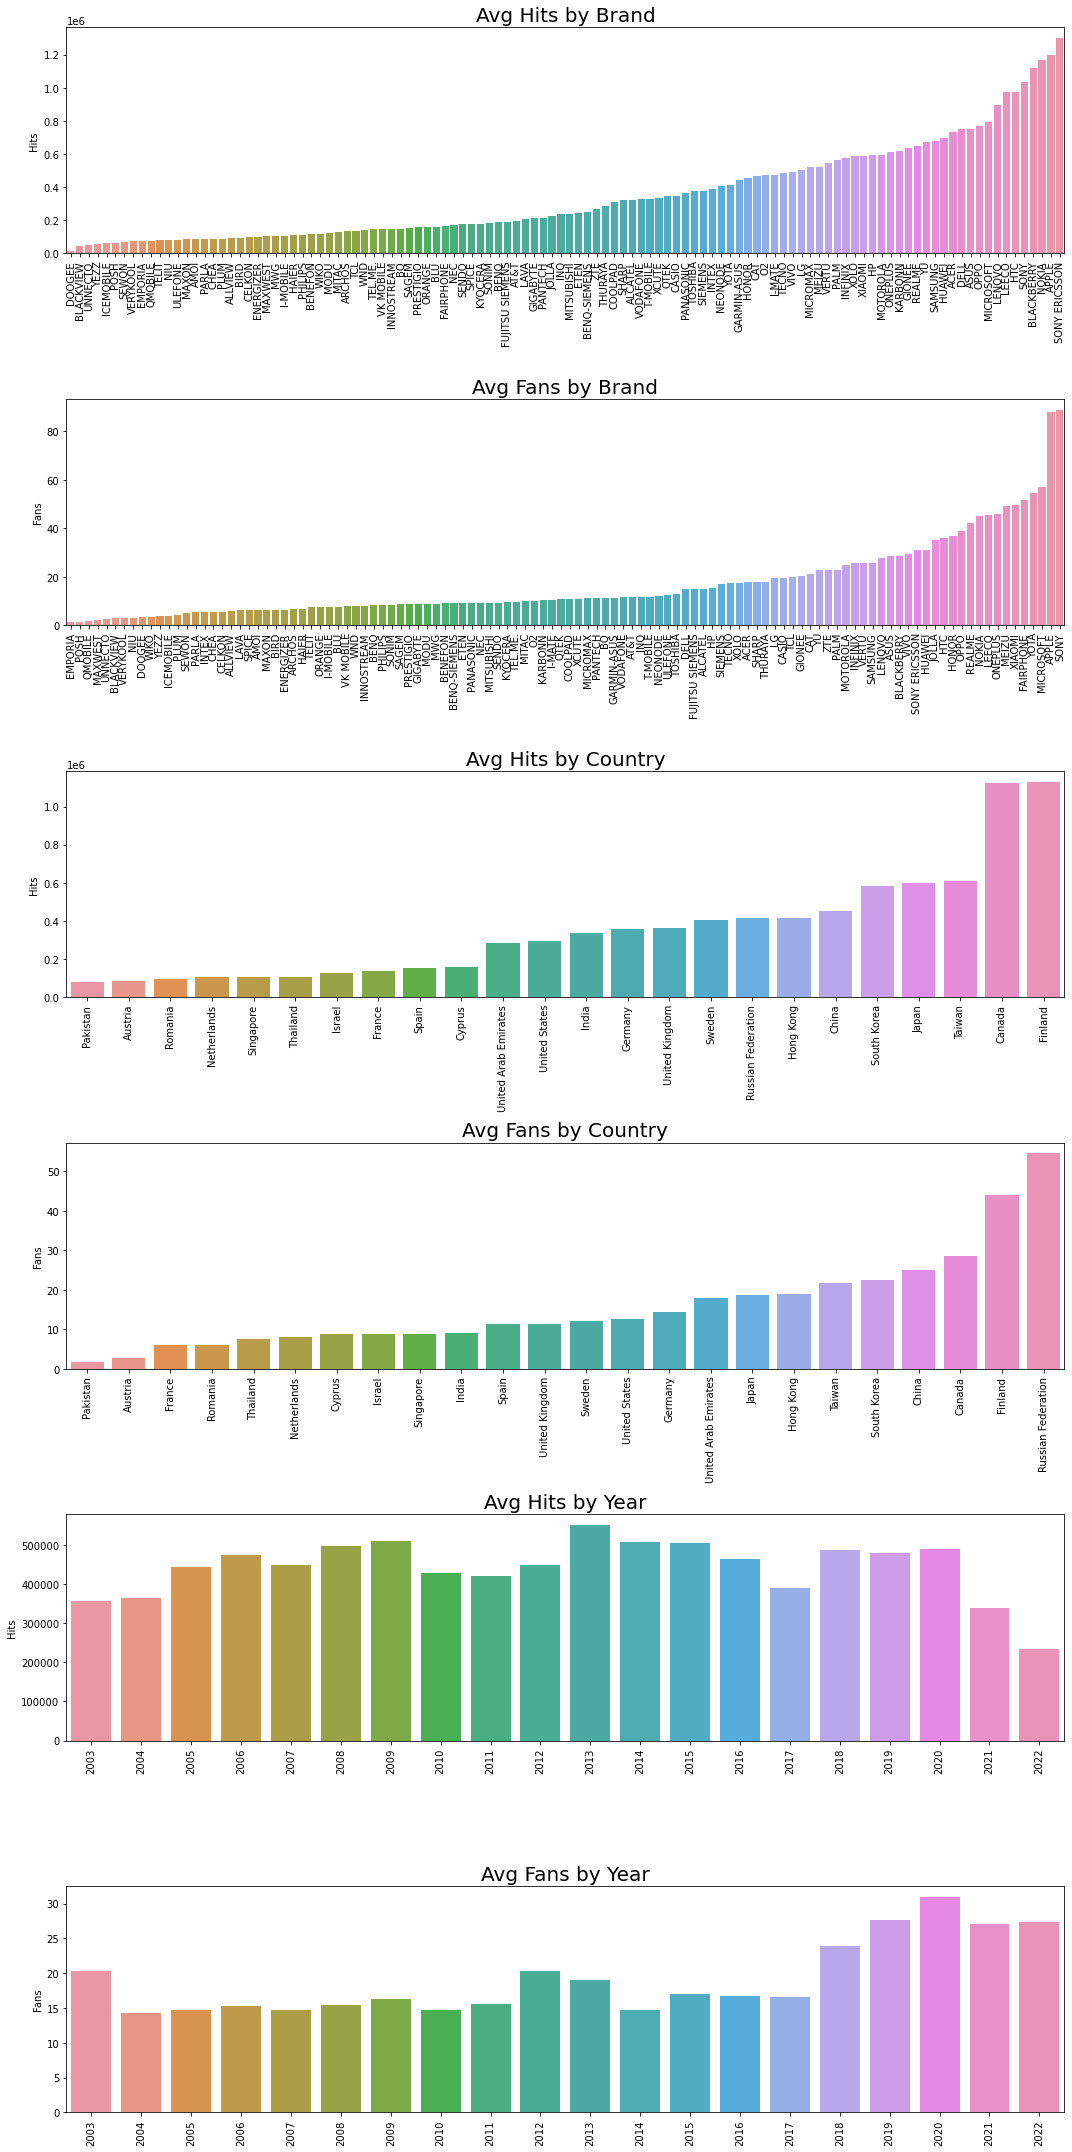

In [69]:
plot_discrete_avgs(df_no_outlires)

In the brands plots we can see that apple and sony/sony ericcson are leading in both avg hits and avg fans, although the kead in fans is much more definative.

In the coutries plots we can see finland is in the top two in both hits and fans (probably due to nokia being a finnish brand).

In the years plot we can see that there is not much difference between most years although in the later years an interesting thing happens, where avg hits gets lower and avg fans gets higher.

### <a class="anchor" id="Maps"></a> Maps

In [183]:
# Getting Hits and Fans avgs by counrty
df_country_avg = df_no_outlires.groupby(['Country'])[['Hits', 'Fans']].mean()

# Getting Countries counts
df_country_cont = df_no_outlires.groupby(['Country'])['Name'].count().reset_index()

#df_country_avg['Count'] = df_country_cont

# Changing names to fit geopandas data
df_country = df_country_avg.merge(df_country_cont, on='Country').rename(columns={'Name':'Count'})
df_country.loc[df_country['Country'] == 'United States', 'Country'] = 'United States of America'
df_country.loc[df_country['Country'] == 'Russian Federation', 'Country'] = 'Russia'

In [184]:
# Getting the geopandas dataset
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Merging the two DataFrames together
df_country = world.merge(df_country, how="left", left_on=['name'], right_on=['Country'])

# Excluding antarctica to make map more readable
df_country = df_country[df_country['continent'] != 'Antarctica']

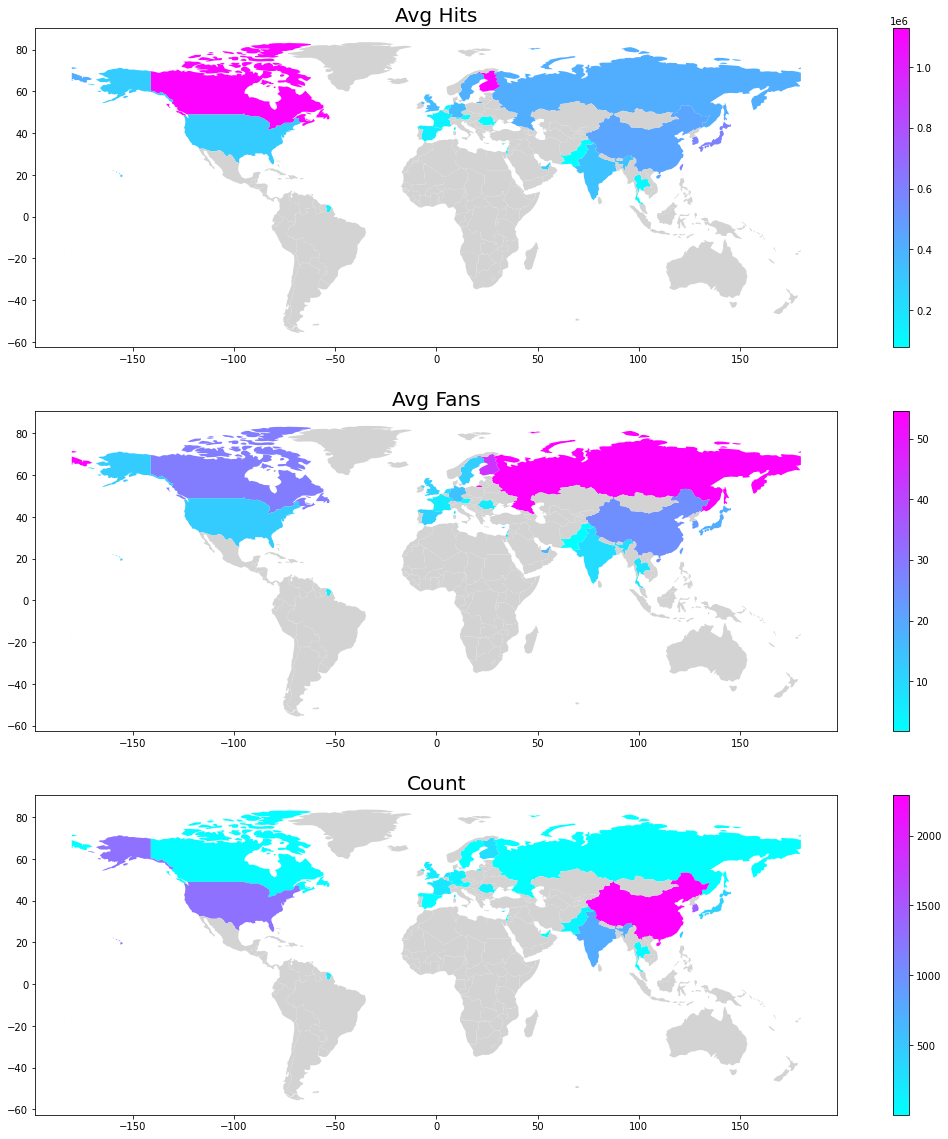

In [185]:
# Plotting maps
fig, ax = plt.subplots(3, 1, figsize=(20, 20))

df_country.plot(ax=ax[0], legend=True, column="Hits", figsize=(20, 20), cmap='cool', missing_kwds={"color": "lightgrey"})
ax[0].set_title('Avg Hits', size=20)
df_country.plot(ax=ax[1], legend=True, column="Fans", figsize=(20, 20), cmap='cool', missing_kwds={"color": "lightgrey"})
ax[1].set_title('Avg Fans', size = 20)
df_country.plot(ax=ax[2], legend=True, column="Count", figsize=(20, 20), cmap='cool', missing_kwds={"color": "lightgrey"})
ax[2].set_title('Count', size = 20)

plt.show()

It is pretty clear that the geographic location / continent does not have much impact on neither the avg hits and fans nor the number of phones.

What we **can** see is that unsuprisingly china has the most phones.

### <a class="anchor" id="CorrelationMatrix"></a> Correlation Matrix

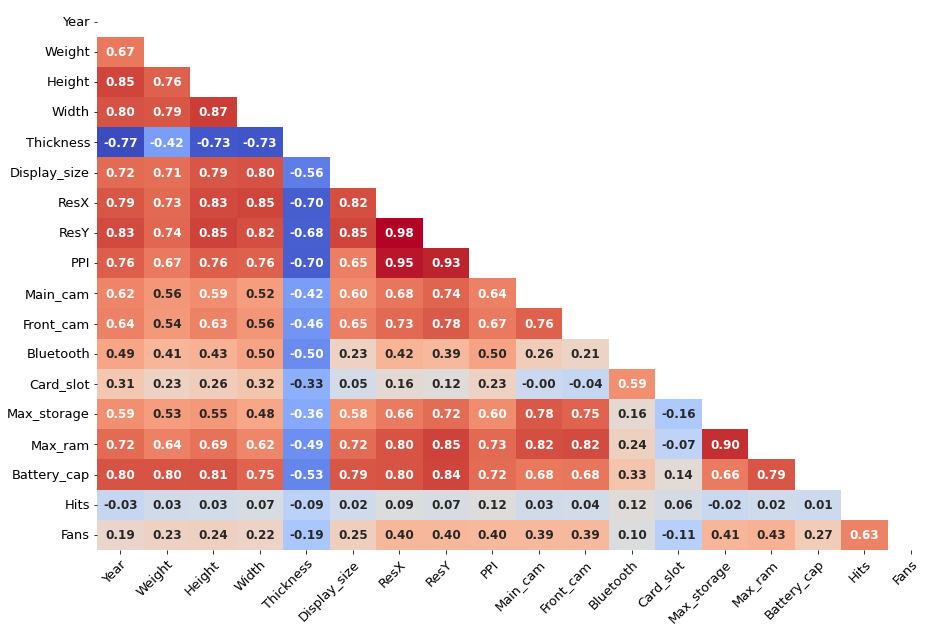

In [73]:
# Plotting correlation heatmap
fig = plt.figure(figsize=(15,10))

corr = df_no_outlires.corr()

sns.heatmap(corr, mask=np.triu(corr), cbar=False, annot=True, cmap='coolwarm', fmt= '.2f',  annot_kws={"size": 12, 'weight':'demi'})
plt.xticks(rotation = 45, rotation_mode='anchor', size=13, ha='right')
plt.yticks(size=13)

plt.show()

One thing that is clear from the matrix is the very low correlation that both our target columns have with the rest of the data.

This is espacialy true in the hits column.

This tells us that there is a high chance that the predictions later on wont be very accurate.

# <a class="anchor" id="MachineLearning"></a> Machine Learning

**sources/credits:**
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://www.kaggle.com/code/arjunprasadsarkhel/simple-random-forest-with-hyperparameter-tuning

### <a class="anchor" id="PreparingTheData"></a> Preparing The Data

After splitting our data to features and targets we split the data to train / test.<br>
We then scale the numeric features using MinMax scaler and encode the discrete features using one-hot encoding (dummies).<br>
We also preform pca on the data.

In [194]:
def preprocess_data(X, y): # Preprocessing the data
    
    # Splitting data to train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Getting numeric features
    X_numeric_cols = X._get_numeric_data().columns
    X_train_numeric = X_train[X_numeric_cols].copy()
    X_test_numeric  = X_test[X_numeric_cols].copy()
    
    # Scaling numeric features
    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_numeric), columns=X_numeric_cols, index=X_train.index)
    X_test_scaled  = pd.DataFrame(scaler.fit_transform(X_test_numeric), columns=X_numeric_cols, index=X_test.index)
    
    # Encoding discrete features
    X_discrete = X.select_dtypes('object').copy()
    X_discrete_dummies = pd.get_dummies(X_discrete, prefix_sep="_")
    X_train_discrete_dummies = X_discrete_dummies.loc[X_train.index,:]
    X_test_discrete_dummies = X_discrete_dummies.loc[X_test.index,:]
    
    # Joining numeric and discrete features
    X_train_processed = pd.concat((X_train_scaled, X_train_discrete_dummies), axis=1)
    X_test_processed = pd.concat((X_test_scaled, X_test_discrete_dummies), axis=1)
    
    # Preforming PCA
    pca = PCA(0.9)
    X_train_reduced = pca.fit_transform(X_train_processed)
    X_test_reduced  = pca.transform(X_test_processed)
    
    return X_train_reduced, X_test_reduced, y_train, y_test


def cv_avg(model, X, y): # Getting avg cross validation score for model
    
    # Getting list of scores
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model , X, y, cv=kfold, scoring='r2')
    
    return scores.mean()


def score_models(models, X, y): # Making dict of model - avg cv score
    
    model_scores = {}
    
    # Getting avg score for each model
    for model in models:
        model_scores[model] = cv_avg(models[model], X, y)
    
    return model_scores


def plot_scores(scores): # Plotting barchart of model scores
    
    fig = plt.figure(figsize=(15,7))
    
    # Making bar plot
    bars = plt.bar(model_scores.keys(), model_scores.values())
    
    # Making labels and title
    plt.bar_label(bars, label_type='edge')
    plt.title('Avg r^2 scores')

    plt.show()

In [195]:
X = df_no_outlires.drop(['Name', 'Hits', 'Fans'], axis=1)
y = df_no_outlires[['Hits', 'Fans']]

In [196]:
X_train, X_test, y_train, y_test = preprocess_data(X, y)

### <a class="anchor" id="ComparingTheModels"></a> Comparing The Models


We now preform a 10-fold cross validation on each of the three models (linear regression, decision tree resgressor and random forest regressor) and compare the average scores of the three.

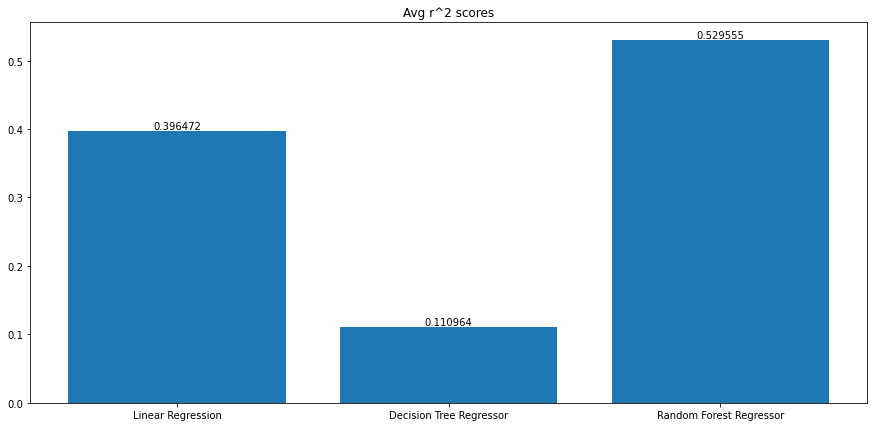

In [193]:
models = {'Linear Regression':LinearRegression(), 
          'Decision Tree Regressor':DecisionTreeRegressor(), 
          'Random Forest Regressor':RandomForestRegressor()}

model_scores = score_models(models, X_train, y_train)

plot_scores(model_scores)

The best preforming model is the Random Forest Regressor with an average R^2 score of 52.9%.

Lets try to make it better by findin the best parameters.

### <a class="anchor" id="HyperparameterTuning"></a> Hyperparameter Tuning

We now preform a Grid Search for the best parameters

In [197]:
model=RandomForestRegressor()

params = {'n_estimators': [100, 200, 500, 800, 1000, 1200],
          'max_features': ['auto', 'sqrt', 'log2', None],
          'max_depth' : [10, 20, 40, 60, None], 
          'bootstrap' : [True, False]}



random_forest_grid = GridSearchCV(model, params, cv = 5, n_jobs = -1, scoring = 'r2', verbose = 2)

random_forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 40, 60, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'n_estimators': [100, 200, 500, 800, 1000, 1200]},
             scoring='r2', verbose=2)

In [198]:
print(random_forest_grid.best_params_)
print(random_forest_grid.best_score_)

{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 1000}
0.5345457380949951


The best perameters are:
bootstrap = True, max_depth = None, max_features = 'auto', n_estimators = 1000

With a score of 53%. 

### <a class="anchor" id="FinalEvaluation"></a> Final Evaluation

Finaly, lets test our best model (Random Forest Regressor) with the best parameters we found on the test data.

In [199]:
forest = RandomForestRegressor(**random_forest_grid.best_params_)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
r2_score(y_test, y_pred)

0.5237357500699535

We got a final score of 52%...

Not bad but not great.